In [29]:
!apt-get update
!apt install xvfb
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!pip install colabgymrender
!sudo pip3 install imageio==2.5
!pip install pygame

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 229 kB in 1s (158 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly i

In [3]:
import numpy as np
import pandas as pd
import gym
from IPython.display import HTML, display
from moviepy.editor import ImageSequenceClip
from base64 import b64encode
import seaborn as sns
import matplotlib.pyplot as plt


  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [4]:
# Helper function to discretize continuous state space
def get_discrete_state(state, obs_low, obs_high, num_bins):
  """
    Convert continuous state to discrete state.
    - state: The continuous state.
    - obs_low: The low bound of the observation space.
    - obs_high: The high bound of the observation space.
    - num_bins: The number of bins for discretization.
  """
  discrete_window_size = (obs_high - obs_low) / np.array(num_bins)
  discrete_state = np.floor((state - obs_low) / discrete_window_size).astype(int)
  return tuple(np.clip(discrete_state, 0, np.array(num_bins) - 1))

# Reward functions
def custom_sparse_reward(position, velocity, steps):
  if position >= 0.5:
    return 1  # Reward for reaching the goal
  else:
    return -0.01  # Small penalty for each step to encourage reaching the goal faster

"""def dense_reward(position, velocity=None, steps=None):
  return -1.0 - position #2 if position >= 0.5 else (position + 1.2) / 1.8 - 1"""
def dense_reward(position, velocity=None, steps=None):
  return 2 if position >= 0.5 else (position + 1.2) / 1.8 - 1

"""def sparse_reward(position):
  return -1.0 if position >= 0.5 else 0.0"""

'def sparse_reward(position):\n  return -1.0 if position >= 0.5 else 0.0'

In [5]:
# Helper function to plot timesteps
def plot_timesteps(timesteps, title, xlabel):
  plt.figure(figsize=(10, 5))
  plt.plot(range(0, len(timesteps) * 100, 100), timesteps, color='blue')
  plt.xlabel(xlabel)
  plt.ylabel('Timesteps')
  plt.title(title)
  plt.grid(True)
  plt.show()

In [ ]:
# Plot combined state action values function
def plot_combined_state_action_values(state_action_matrix, state_visits, num_bins):
  """
  Plot the state-action heatmaps and the 3D plot

  Args:
  - state_action_matrix: Contains the Q-values
  - state_visits: Array recording the number of visits to each state-action pair.
  - num_bins: The number of bins for discretizing the observation space
  """

  # Generate position and velocity spaces based on the number of bins to use (20)
  position_space = np.linspace(-1.2, 0.6, num_bins[0])
  velocity_space = np.linspace(-0.07, 0.07, num_bins[1])

  # Action labels
  actions = ['Left', 'Neutral', 'Right']

  fig, axes = plt.subplots(1, 3, figsize=(18, 6))

  # Loop through each action to plot the heatmap
  for i, action in enumerate(actions):
    # Extract visit counts
    visits = state_visits[:, :, i]

    # Create a heatmap for the current action
    sns.heatmap(visits, xticklabels=np.round(velocity_space, 2), yticklabels=np.round(position_space, 2), ax=axes[i], cmap='viridis')

    axes[i].set_title(f'Visits for action: {action}')
    axes[i].set_xlabel('Velocity')
    axes[i].set_ylabel('Position')

  # Adjust layout
  plt.tight_layout()

  # Display the heatmap
  plt.show()

  # Create a figure for the 3D plot
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Consistent errors about the datatype led me to determine if the state_action_matrix is a DataFrame or an np array. reshape it
  if isinstance(state_action_matrix, pd.DataFrame):
    # If it's a DataFrame, get the max values across actions and reshape it to match the 20 bins
    max_values = state_action_matrix.max(axis=1).values.reshape(num_bins[0], num_bins[1])
  else:
    # If it's a numpy array, get the max values across the actions third dimension and reshape
    max_values = state_action_matrix.max(axis=2).reshape(num_bins[0], num_bins[1])

  # Generate meshgrid for position and velocity spaces
  X, Y = np.meshgrid(velocity_space, position_space)
  Z = max_values

  # Create 3D surface plot of the maximum state-action values
  surf = ax.plot_surface(X, Y, Z, cmap='viridis')

  # Add a color bar to indicate the scale of values
  fig.colorbar(surf)

  # Set the title and axis labels for the 3D plot
  ax.set_title('Maximum State-Action Values')
  ax.set_xlabel('Velocity')
  ax.set_ylabel('Position')
  ax.set_zlabel('Value')

  # Display the 3D surface plot
  plt.show()


In [ ]:
# Helper function to watch the trained agent
def watch_trained_agent(env, agent, num_bins, num_episodes=1):
    """
    Generates a video of the trained agent.
    Args:
    - env: The environment (Mountain CAr)
    - agent: The agent. also called participant in the ga. It's the Q-table for Q-learning.
    - num_bins: The number of bins for discretizing the observation space (20)
    - num_episodes: The number of episodes (to record)
    """

    frames = []  # List to store frames

    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment to get the initial state
        done = False  # Flag to indicate if the episode is done

        while not done:
            frame = env.render(mode='rgb_array')  # Render the environment and get the frame
            frames.append(frame)  # Add frame to the list
            state_adj = get_discrete_state(state, env.observation_space.low, env.observation_space.high, num_bins)  # Discretize the state (for the observation space, which is continuous, but cannot be maintained as continuous for the implementations...)

            # Select action based on the type of agent
            action = agent.select_action(state_adj) if isinstance(agent, Participant) else np.argmax(agent[state_adj])

            state, _, done, _ = env.step(action)  # Take the action and get the next state and done flag

    env.close()  # Close the environment

    clip = ImageSequenceClip(frames, fps=30)  # Create a video clip from the frames
    video_file = "simulation_video.mp4"  # File name for the video
    clip.write_videofile(video_file)  # Write the video file

    with open(video_file, "rb") as f:
        video_b64 = b64encode(f.read()).decode()  # Read the video file

    # Return the HTML object embedding the video
    return HTML(f'<video width="600" controls><source src="data:video/mp4;base64,{video_b64}" type="video/mp4"></video>')


In [6]:
"""
Difficulty plotting a descriptive state-action table for the GA led to directly following the agent trajectory in order to visualize it's reasoning in a more descriptive manner.
Args:
  - env: The environment (Mountain CAr)
  - agent: The agent. also called participant in the ga. It's the Q-table for Q-learning.
  - num_bins: The number of bins for discretizing the observation space (20)

    This function generates heatmaps to show the frequency of visits to each state-action pair for each possible action in the action space.

"""

def plot_trajectory_heatmap(agent, environment, num_bins):
  # Initialize a 3D array to record state-action visit counts
  state_visits = np.zeros((num_bins[0], num_bins[1], 3))

  observation = environment.reset()  # Reset the environment to get the initial state
  done = False  # Initialize the done flag to indicate the episode is not finished yet


  while not done:
    # Discretize the state
    discrete_state = get_discrete_state(observation, environment.observation_space.low, environment.observation_space.high, num_bins)
    # Select an action with the trained agent
    action = agent.select_action(discrete_state)
    # Increment the visit count for the current state-action pair
    state_visits[discrete_state[0], discrete_state[1], int(action)] += 1
    # Execute the action
    observation, _, done, _ = environment.step(int(action))

  # Define position and velocity spaces for the heatmaps
  position_space = np.linspace(-1.2, 0.6, num_bins[0])
  velocity_space = np.linspace(-0.07, 0.07, num_bins[1])
  actions = ['Left', 'Neutral', 'Right']

  fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Create a figure with 3 subplots arranged in a row for the heatmaps
  for i, action in enumerate(actions):
    sns.heatmap(state_visits[:, :, i], xticklabels=np.round(velocity_space, 2), yticklabels=np.round(position_space, 2), ax=axes[i], cmap='viridis')
    axes[i].set_title(f'Visits for action: {action}')
    axes[i].set_xlabel('Velocity')
    axes[i].set_ylabel('Position')
  plt.tight_layout()
  plt.show()


# GA Agent implementation

In [7]:
# Agent/participant class for Genetic Algorithm (GA) implementation
class Participant:
  """
    A state action table is the equivalent of a Q table (For Q-learning)
    Basically a lookup table used to store and retrieve values that represent the utility of taking an action.
    - performance_score: The performance score of the participant, used to evaluate its fitness.
    - total_reward: The total reward obtained by the participant during evaluation.
    """

    """
    Building the SA table:
      State: REpresentation of the current situation. Here it could be the altitude of the car?
      Action: What the agent can do. Thus: 0, 1, 2 (go left, stay, or go right)
      - state_action_matrix: A DataFrame representing the state-action table with randomly initialized values.
    Purpose of the table:
      Guide the agent's decision-making process.
      By consulting the table, the agent can choose the action with the highest expected reward in a given state.
    """



  def __init__(self, environment, num_bins):
    self.environment = environment
    self.num_bins = num_bins
    # Initialize the state-action matrix with random values between -1 and 1.
    # The matrix has (num_bins[0] * num_bins[1]) rows (one for each discretized state) and 3 columns (one for each action)
    self.state_action_matrix = pd.DataFrame(
      np.random.uniform(-1, 1, size=(num_bins[0] * num_bins[1], 3)),
      columns=[0, 1, 2],
      dtype=np.float64
    )
    self.state_action_matrix.index = pd.MultiIndex.from_product([range(num_bins[0]), range(num_bins[1])])
    self.performance_score = None
    self.total_reward = None

  def select_action(self, state_obs):
    """
    Selects the best action based on the current state
    Args:
    - state_obs: The current state

    Returns:
    - chosen_action: The action with the highest value for the current state, converted to an integer.
    """
    # Retrieve the action values for the current state from the state-action matrix.
    action_values = self.state_action_matrix.loc[state_obs, :]
    # Choose the action with the highest value
    chosen_action = action_values.idxmax()
    return int(chosen_action)

  def create_state(self, state_obs):
    """
    Creates a new state in the state-action matrix with random values .

    Args:
    - state_obs: The new state observation
    """
    # Initialize the action values for the new state with random numbers between -1 and 1.
    action_values = {i: np.random.uniform(-1, 1) for i in range(self.environment.action_space.n)}
    # Create a new Series for the new state with the initialized action values.
    new_state = pd.Series(action_values, name=state_obs)
    # Add the new state to the state-action matrix.
    self.state_action_matrix = pd.concat([self.state_action_matrix, new_state.to_frame().T])
    # Fill in any missing values in the matrix with random numbers between -1 and 1.
    self.state_action_matrix.fillna(np.random.uniform(-1, 1), inplace=True)

In [21]:
# Evolutionary Algorithm class
class EvolutionaryAlgorithm:
  """
  Genetic Algorithm (GA) used to train the agents
  The GA evolves a population of participants (agents) over multiple generations to optimize their performance.

  Attributes:
  - pop_size: The size of the population (100)
  - gen_count: The number of generations used (100)
  - mut_rate: The mutation rate
  - elite_frac: The elite population amount that will be carried to the next generation.
  - adapt_mut: A NOT USED flag in the final implementation
  - num_bins: The number of bins for discretizing the space (20)
  - population: The current population of agents
  - best_participant: The best participant in the current population
  - reward_function: The function used to calculate the reward for each state. Here is where the sparse and dense reward systes are applied on first instace.
  """
  def __init__(self, pop_size, gen_count, mut_rate=0.1, elite_frac=0.1, adapt_mut=False, num_bins=(20, 20), reward_function=None):
    self.pop_size = pop_size
    self.gen_count = gen_count
    self.mut_rate = mut_rate
    self.elite_frac = elite_frac
    self.adapt_mut = adapt_mut
    self.num_bins = num_bins
    self.population = []
    self.best_participant = None
    self.reward_function = reward_function

  def train(self, environment):
    """
    Trains the population

    Args:
    - environment: The environment (mountain car)

    This method initializes the population, evaluates each agent's performance, does crossover and mutation, and selects the top performers.
    Also tracks the timesteps and visualizes the state-action values and state visits.
    """
    self.initialize_population(environment)
    generation_timesteps = []
    state_visits = np.zeros((self.num_bins[0], self.num_bins[1], environment.action_space.n))

    for gen in range(self.gen_count):
      print(f"Generation {gen+1}/{self.gen_count}")
      self.evaluate_population(environment, state_visits)
      if self.best_participant is not None:
          generation_timesteps.append(self.best_participant.performance_score)
      else:
          generation_timesteps.append(None)
          print("Warning: Best participant is None after evaluation.")

      self.crossover_and_mutate(environment)
      self.population = self.select_top_performers(self.population)
      self.best_participant = self.population[0] if self.population else None
      print(f"Best Participant Timesteps: {self.best_participant.performance_score if self.best_participant else 'None'}")

    plot_combined_state_action_values(self.best_participant.state_action_matrix, state_visits, self.num_bins)
    return generation_timesteps

  def initialize_population(self, environment):
    """
    Initializes the population with random participants.

    This method creates a new participant for each individual in the population, evaluates their performance, and appends them to the population list. The best participant is also determined here.
    """
    for _ in range(self.pop_size):
      participant = Participant(environment, self.num_bins)
      participant.performance_score, participant.total_reward = self.evaluate_performance(participant, environment)
      self.population.append(participant)
    self.best_participant = self.population[0] if self.population else None

  def crossover_and_mutate(self, environment):
    """
    Performs crossover and mutation to create the next generation of agents.
    """
    next_gen = []
    elite_count = int(self.elite_frac * self.pop_size)
    elite_participants = self.population[:elite_count]
    next_gen.extend(elite_participants)
    print(f"Elites from previous generation (reward): {[p.total_reward for p in elite_participants]}")

    while len(next_gen) < self.pop_size:
      parent1, parent2 = np.random.choice(self.population[:elite_count], 2, replace=False)
      offspring1, offspring2 = self.combine_genes(parent1, parent2, environment)
      offspring1 = self.mutate(offspring1, environment)
      offspring2 = self.mutate(offspring2, environment)
      offspring1.performance_score, offspring1.total_reward = self.evaluate_performance(offspring1, environment)
      offspring2.performance_score, offspring2.total_reward = self.evaluate_performance(offspring2, environment)
      next_gen.extend([offspring1, offspring2])

    self.population = next_gen[:self.pop_size]

  def combine_genes(self, parent1, parent2, environment):
    """
    Combines the genes (state-action matrices) of two parents to create two offspring agents.
    """
    offspring1 = Participant(environment, self.num_bins)
    offspring2 = Participant(environment, self.num_bins)

    crossover_point = np.random.randint(1, len(parent1.state_action_matrix.columns))

    offspring1.state_action_matrix = pd.concat([parent1.state_action_matrix.iloc[:, :crossover_point], parent2.state_action_matrix.iloc[:, crossover_point:]], axis=1)
    offspring2.state_action_matrix = pd.concat([parent2.state_action_matrix.iloc[:, :crossover_point], parent1.state_action_matrix.iloc[:, crossover_point:]], axis=1)

    offspring1.state_action_matrix = self.clean_state_action_matrix(offspring1.state_action_matrix)
    offspring2.state_action_matrix = self.clean_state_action_matrix(offspring2.state_action_matrix)

    return offspring1, offspring2

  def clean_state_action_matrix(self, state_action_matrix):
    """
    Cleans the state-action matrix by shuffling and filling missing values.
    """
    state_action_matrix = state_action_matrix.sample(frac=1)
    state_action_matrix.fillna(np.random.uniform(-1, 1), inplace=True)
    return state_action_matrix[~state_action_matrix.index.duplicated(keep='first')]

  def mutate(self, participant, environment):
    """
    Mutates the state-action matrix of a participant.

    This method randomly alters the action values in the matrix with a comparison with the mutation rate.
    """
    for _, row in participant.state_action_matrix.iterrows():
      if np.random.uniform() < self.mut_rate:
          row[:] = environment.action_space.sample()
    participant.state_action_matrix.fillna(np.random.uniform(-1, 1), inplace=True)
    return participant

  def evaluate_population(self, environment, state_visits):
     """
        Evaluates the performance of a participant.

        Args:
        - participant: The agent whose performance is to be evaluated.
        - environment
        - state_visits: Array to track the visits to each state-action pair.
        """
    for individual in self.population:
      individual.performance_score, individual.total_reward = self.evaluate_performance(individual, environment, state_visits)
      print("reward: ", individual.total_reward)

  def evaluate_performance(self, participant, environment, state_visits=None):
    """
    Evaluates the performance of a participant/agent.

    Returns:
    - A tuple containing the performance score and total reward.
    - The performance score will vary depending on whether the closest goal distance is employed or not.
    """
    observation = environment.reset()
    done = False
    closest_goal_distance = float('inf')
    actions_count = 0
    total_reward = 0

    while not done:
      discrete_state = get_discrete_state(observation, environment.observation_space.low, environment.observation_space.high, self.num_bins)
      action = participant.select_action(discrete_state)
      observation, _, done, _ = environment.step(int(action))
      goal_distance = 0.6 - observation[0]
      total_reward += self.reward_function(observation[0], observation[1], actions_count)
      if goal_distance < closest_goal_distance:
          closest_goal_distance = goal_distance
      actions_count += 1

      if state_visits is not None:
          state_visits[discrete_state[0], discrete_state[1], action] += 1

    """
    Very important to notice that results vary depending on which return function is used here.
    Both options are tried at different points.
    """
    #return closest_goal_distance + actions_count, total_reward
    return actions_count + self.reward_function(observation[0], observation[1], actions_count), total_reward

  def select_top_performers(self, population):
    return sorted(population, key=lambda x: x.performance_score, reverse=False)

In [11]:
# Train and visualize the GA agent
def train_and_visualize_ga_agent(reward_function, title_suffix):
  print(f"Training with {title_suffix} reward")
  env = gym.make("MountainCar-v0")
  evo_alg = EvolutionaryAlgorithm(pop_size=100, gen_count=100, mut_rate=0.05, elite_frac=0.2, num_bins=(20, 20), reward_function=reward_function)
  generation_timesteps = evo_alg.train(env)

  plot_timesteps(generation_timesteps, f'Timesteps vs Generations ({title_suffix} reward)', 'Generations')
  plot_trajectory_heatmap(evo_alg.best_participant, env, num_bins=(20, 20))
  HTML_video_ga = watch_trained_agent(env, agent=evo_alg.best_participant, num_bins=(20, 20))
  display(HTML_video_ga)

In [25]:
# Q-learning algorithm
def q_learning(env, learning_rate, epsilon, min_epsilon, num_episodes, num_bins=(20, 20), reward_function=dense_reward):
  """
  Arguments:
  - env: The environment (of course) (MountainCar-v0).
  - learning_rate: The learning rate for Q-learning updates.
    - Usually denoted as alpha.
    - Controls how much new information overrides the old information.
    - Purpose: Determining the extent to which the Q-values are updated during the learning process.
  - epsilon: Exploration rate.
    - Uses an 'epsilon-greedy policy', to balance exploration and exploitation.
    - Purpose: Dictating the probability of the agent choosing a random action (exploration) vs action with the highest Q-value (exploitation).
    - Epsilon decays over time to reduce exploration as the agent learns more.
    - Decrease occurs after each episode (perhaps should be changed to after getting some sort of reward???? so that the exploration in the dense reward environment works better?
  - min_epsilon: The minimum exploration rate.
  - num_episodes: The number of episodes to train the agent.
  - num_bins: The number of bins for discretizing the state space.
  - reward_function: The function to calculate the reward for each state.

  Returns:
  - reward_statistics: The rewards obtained in each episode.
  - Q: The final Q-table.
  """

  # Define state space boundaries
  obs_low = env.observation_space.low
  obs_high = env.observation_space.high

  # Initialize Q-table with random values between -1 and 0
  Q = np.random.uniform(low=-1, high=0, size=(num_bins[0], num_bins[1], env.action_space.n))

  # Initialize lists to store reward statistics
  reward_statistics = []
  episode_timesteps = []
  state_visits = np.zeros((num_bins[0], num_bins[1], env.action_space.n))
  first_success = num_episodes + 1

  # Training loop over the specified number of episodes
  for episode in range(num_episodes):
    state = env.reset() # Reset the environment to get the initial state
    state_adj = get_discrete_state(state, obs_low, obs_high, num_bins)# Discretize the state
    done = False
    total_reward = 0
    actions_count = 0
    closest_goal_distance = float('inf')

    while not done:
      # Select an action using epsilon-greedy policy
      if np.random.random() > epsilon: # Is random number bigger than epsilon?
        action = np.argmax(Q[state_adj]) #Take action that maximizes q-value
      else:
        action = env.action_space.sample() #take random action

      # Execute the action
      next_state, _, done, _ = env.step(action) # next_state is the state of the environment post action being performed. done means, well, if the episode is over or not.
      next_state_adj = get_discrete_state(next_state, obs_low, obs_high, num_bins) # Discretize the next state

      goal_distance = 0.6 - next_state[0]
      if goal_distance < closest_goal_distance:
        closest_goal_distance = goal_distance

      """
      Here, just like in the GA algorithm, using the closest_goal_distance to influence on rewards is optional.
      Both approaches are tried, and they tend to yield different results.
      """
      reward = reward_function(next_state[0], next_state[1], actions_count)
      reward = reward_function(next_state[0], next_state[1], actions_count) - closest_goal_distance
      total_reward += reward

      # Update Q-value using the Q-learning update rule
      max_q_next = np.max(Q[next_state_adj])
      Q[state_adj[0], state_adj[1], action] += learning_rate * (reward + max_q_next - Q[state_adj[0], state_adj[1], action])
      state_visits[state_adj[0], state_adj[1], action] += 1
      # Move to the next state
      state_adj = next_state_adj
      actions_count += 1

      # Track first successful episode
      if next_state[0] >= 0.5 and episode < first_success:
        first_success = episode
        print(f"First clear on episode {episode + 1}")

    # Decay epsilon to reduce exploration over time and prioritize exploitation
    epsilon = max(min_epsilon, epsilon * 0.995)
    # Collect rewards for statistics
    reward_statistics.append(total_reward)
    if (episode + 1) % 100 == 0:
      episode_timesteps.append(actions_count)

    # Print average reward every 100 episodes
    if (episode + 1) % 100 == 0 or episode == 0:
      avg_reward = np.mean(reward_statistics[-100:])
      avg_timesteps = np.mean(episode_timesteps[-1:])
      print(f'Episode {episode + 1} Average reward: {avg_reward}, Average timesteps: {avg_timesteps}')

  env.close()
  combined_metric = [r + actions_count for r, actions_count in zip(reward_statistics, episode_timesteps)]
  plot_combined_state_action_values(Q, state_visits, num_bins)
  return episode_timesteps, Q

# Train the Q-learning agent with dense reward
env = gym.make("MountainCar-v0")

  deprecation(

  deprecation(



## Visualize GA agent with the closest goal distance implementation

  if not isinstance(terminated, (bool, np.bool8)):



Streaming output truncated to the last 5000 lines.
reward:  -97.1063071936369
reward:  -70.88844846584834
reward:  -106.70869307406247
reward:  -91.81027276697569
reward:  -88.23771846294403
reward:  -83.67211326723918
reward:  -77.84380031563342
reward:  -98.50606524152681
reward:  -92.65815135813318
reward:  -74.38887679576874
reward:  -87.1860516667366
reward:  -83.6619725554483
reward:  -69.96533635258675
reward:  -82.68743417412043
reward:  -86.04556131362915
reward:  -86.42501518130302
reward:  -73.68210316449404
reward:  -75.86208941042423
reward:  -83.41605173036805
reward:  -83.88148696534336
reward:  -78.28828780865297
reward:  -86.00801920890808
reward:  -71.21048220992088
reward:  -70.44861820340157
reward:  -70.16924883425236
reward:  -73.99538443796337
reward:  -85.9931498169899
reward:  -70.66150246141478
reward:  -91.6340166144073
reward:  -71.31834037601948
reward:  -86.34315253607929
reward:  -85.78623539209366
reward:  -92.55507683753967
reward:  -79.4246505945921
re

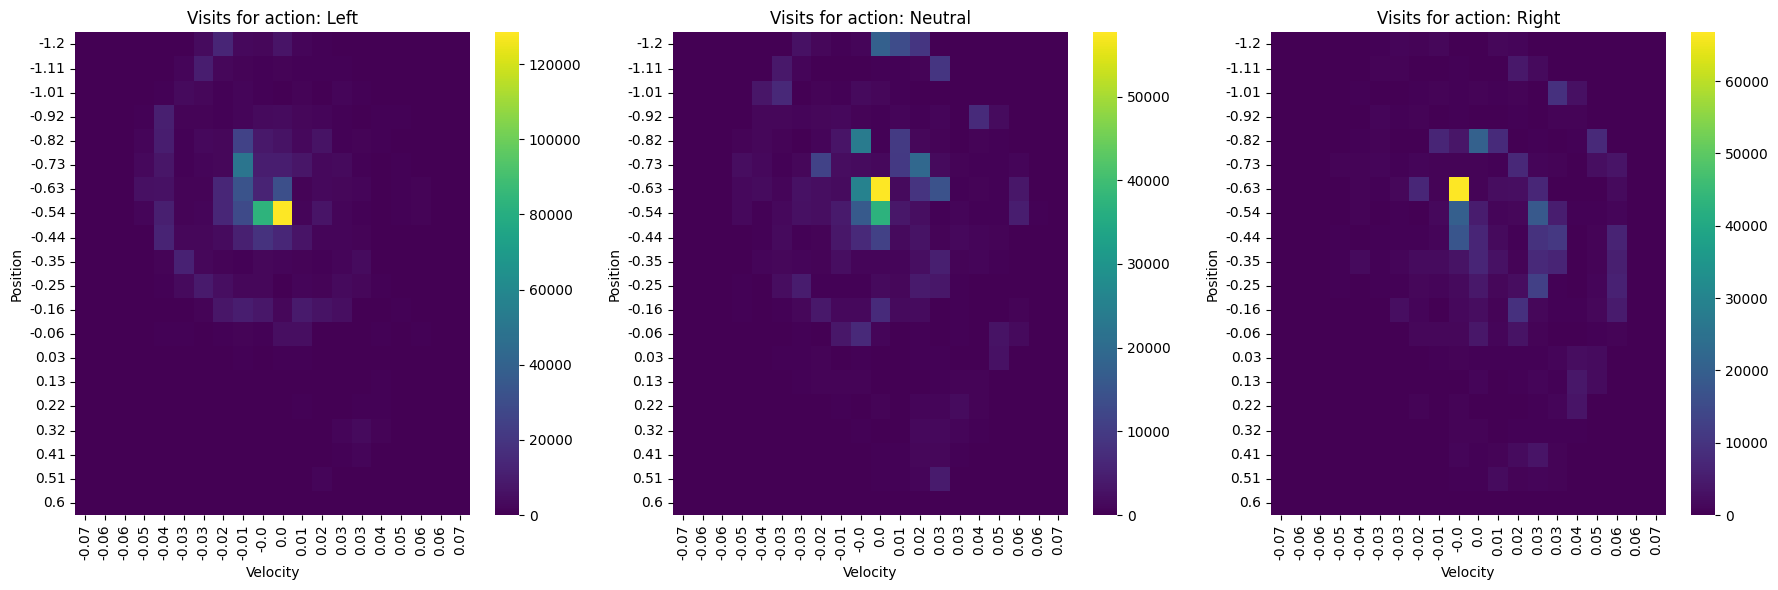

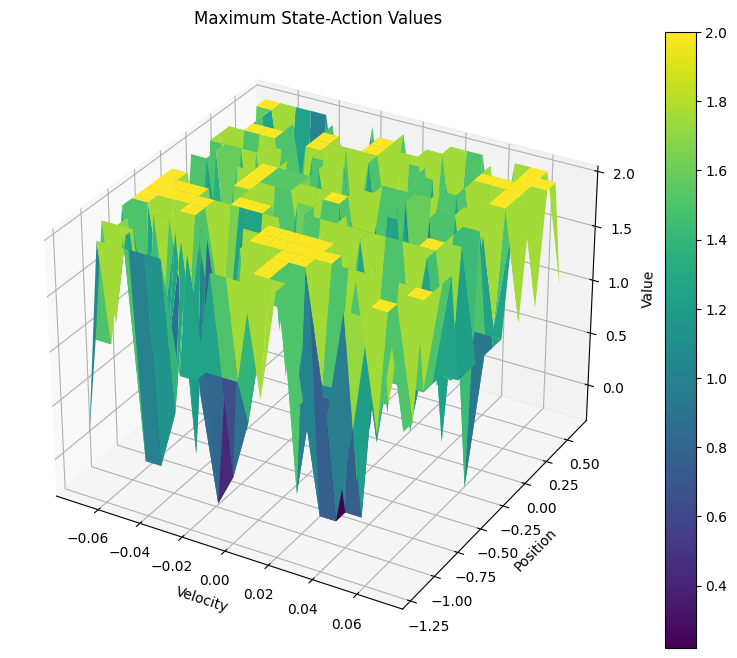

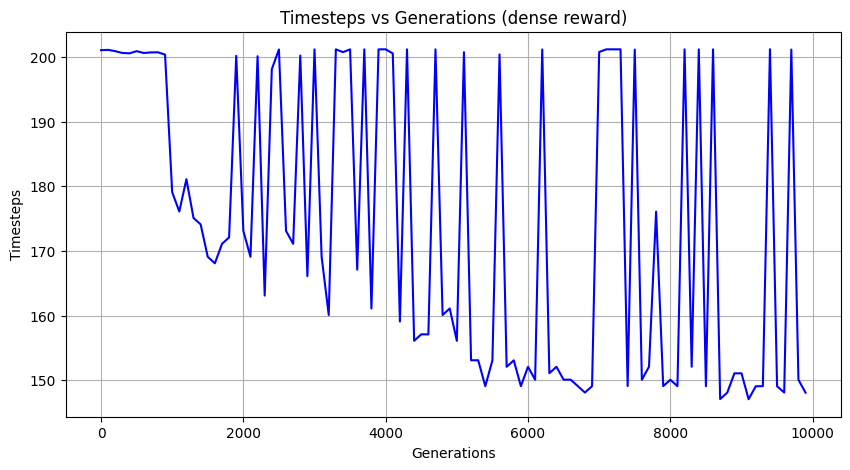

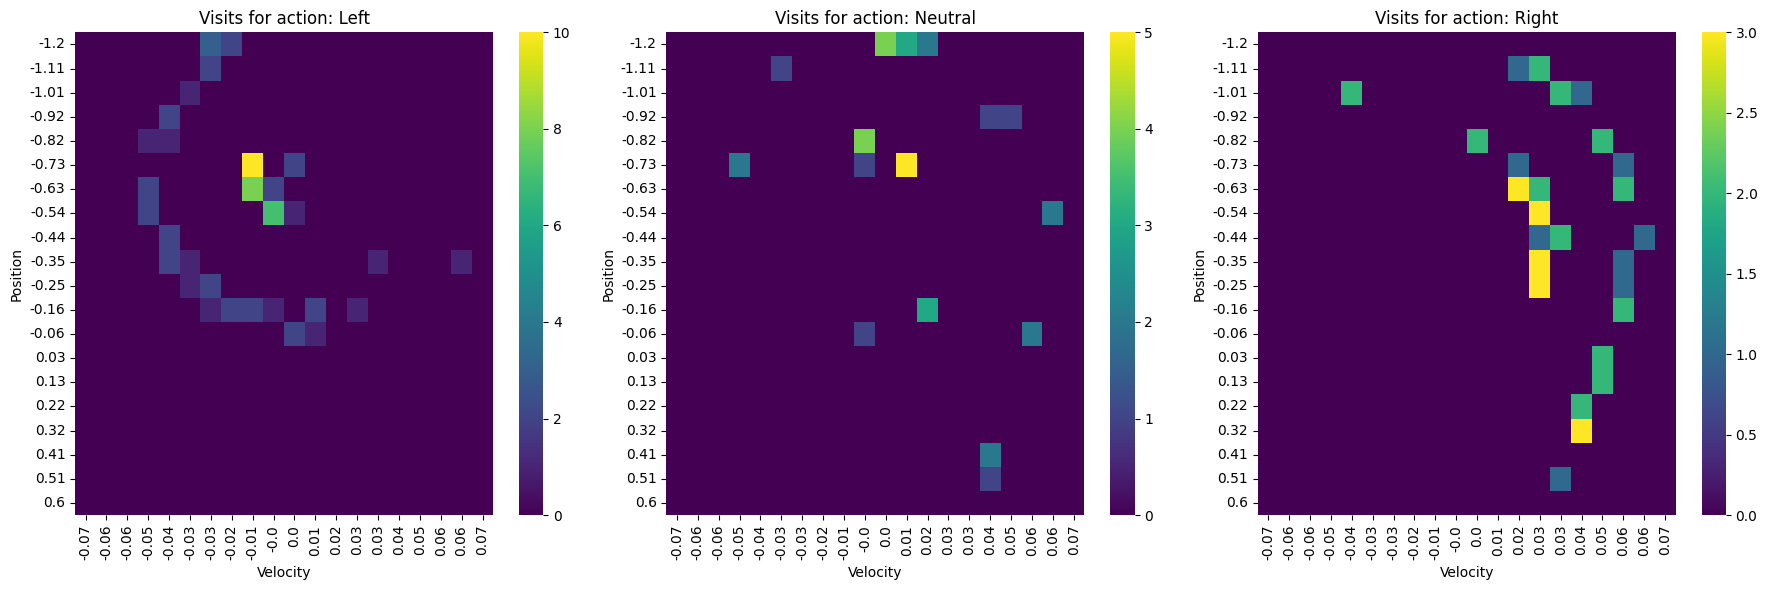

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [ ]:
# Train and visualize the GA agent with dense reward
train_and_visualize_ga_agent(dense_reward, "dense")

  deprecation(

  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



Streaming output truncated to the last 5000 lines.
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.000000000

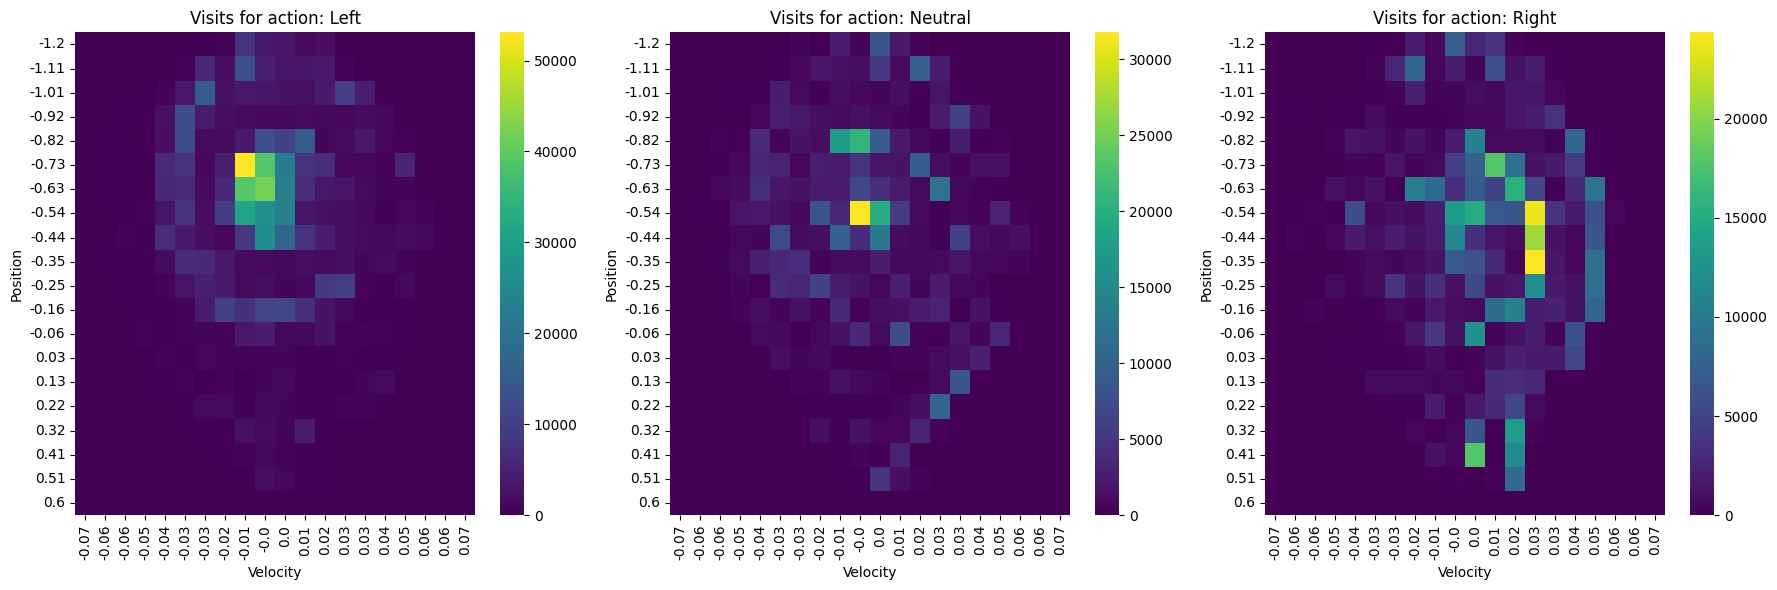

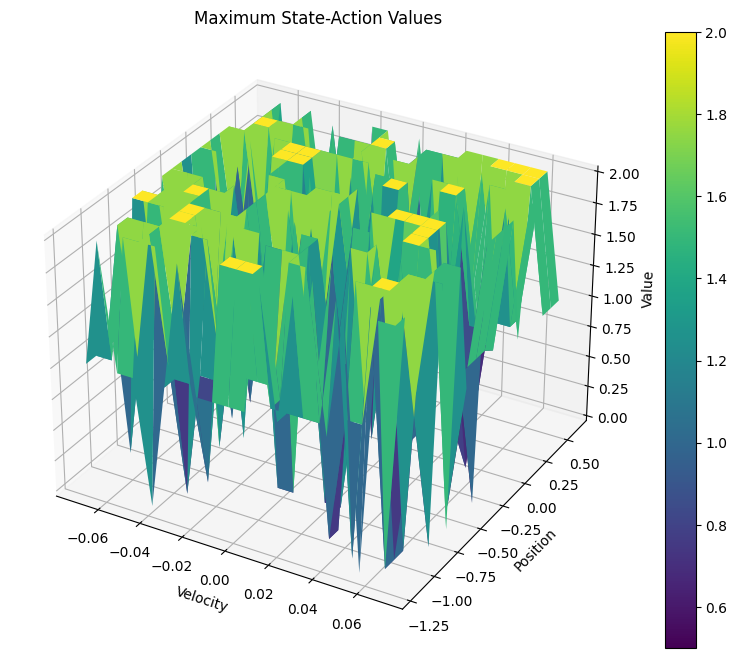

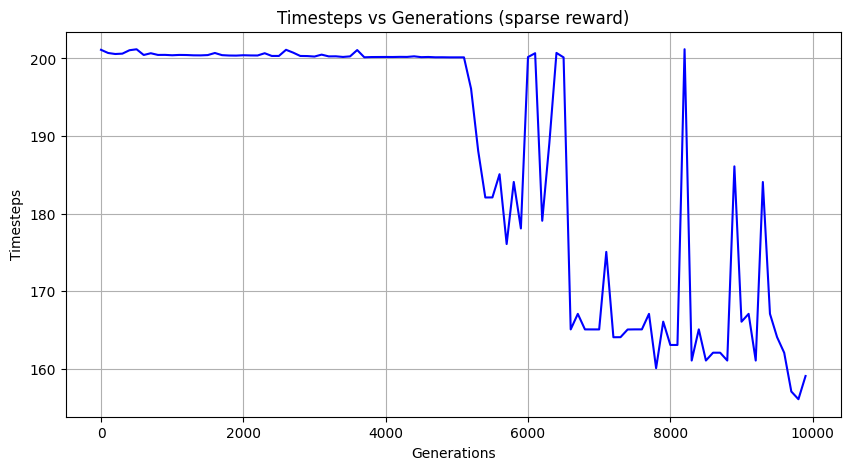

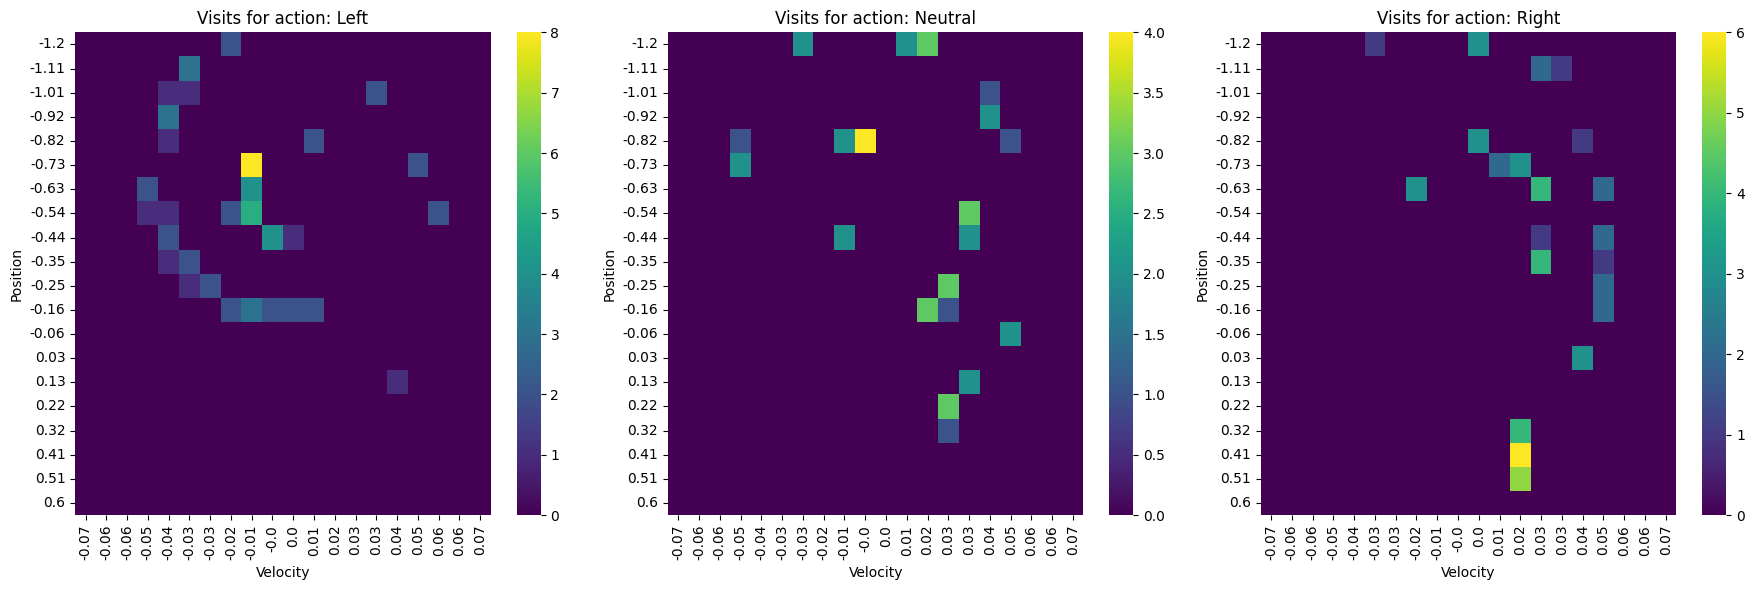

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [ ]:
# Train and visualize the GA agent with custom sparse reward
train_and_visualize_ga_agent(custom_sparse_reward, "sparse")

## Experiment Re-do without closest goal distance implementation for GA

  deprecation(

  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



Streaming output truncated to the last 5000 lines.
reward:  -135.16117417150068
reward:  -132.76215612060506
reward:  -134.68047609759705
reward:  -136.58374753263263
reward:  -132.53344740304675
reward:  -131.1092242598534
reward:  -131.65752842194505
reward:  -133.7760393362906
reward:  -130.09177016456502
reward:  -129.80747538308296
reward:  -128.2043640584581
reward:  -131.55288164400386
reward:  -132.3664069424073
reward:  -128.09054093228454
reward:  -128.34867130137158
reward:  -132.039284867545
reward:  -129.56888157460426
reward:  -132.3750828868813
reward:  -128.80391716957092
reward:  -128.88135482039726
reward:  -133.1246007151073
reward:  -138.68962056106992
reward:  -129.00607348316245
reward:  -129.11370379229388
reward:  -132.12085104237002
reward:  -128.45509395831152
reward:  -131.2217215200266
reward:  -135.05928958455723
reward:  -134.9572110341655
reward:  -124.86199774675899
reward:  -127.23637375175406
reward:  -121.38627418213417
reward:  -127.96525930364918
re

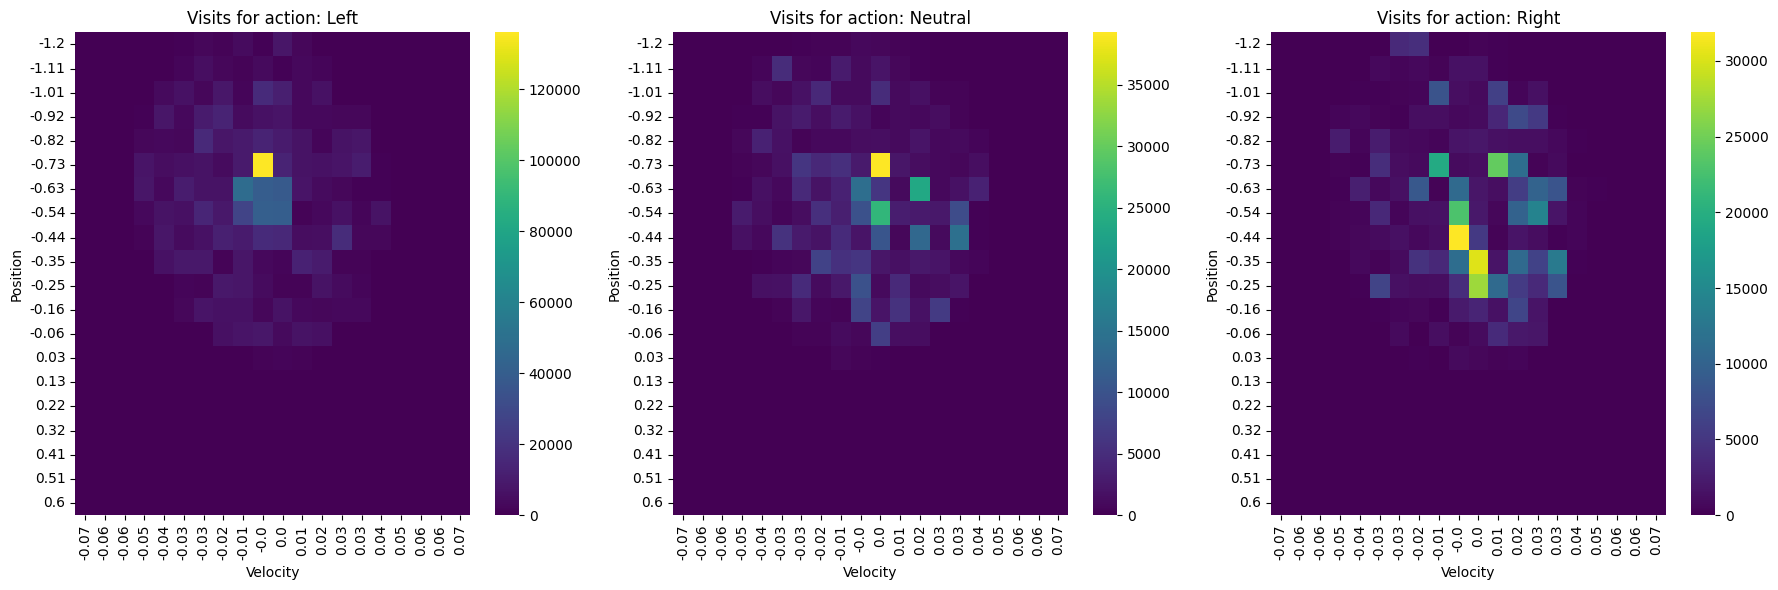

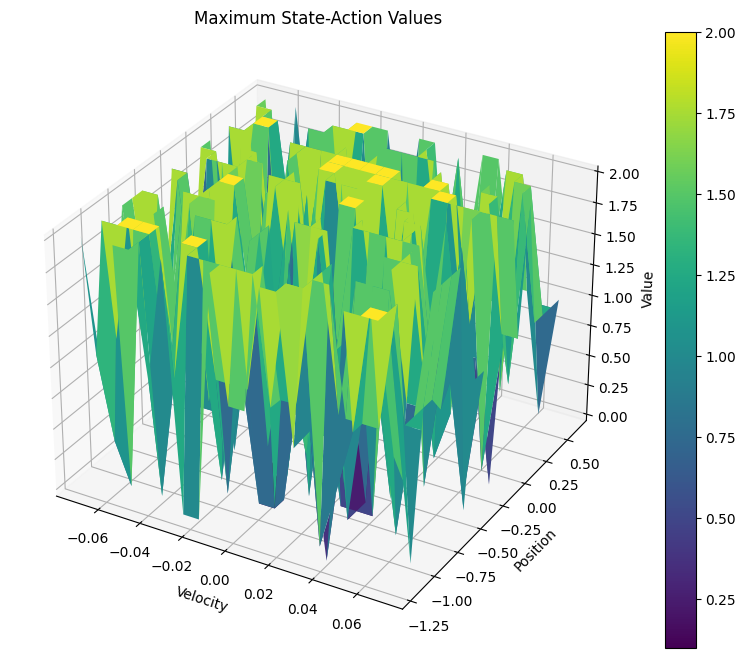

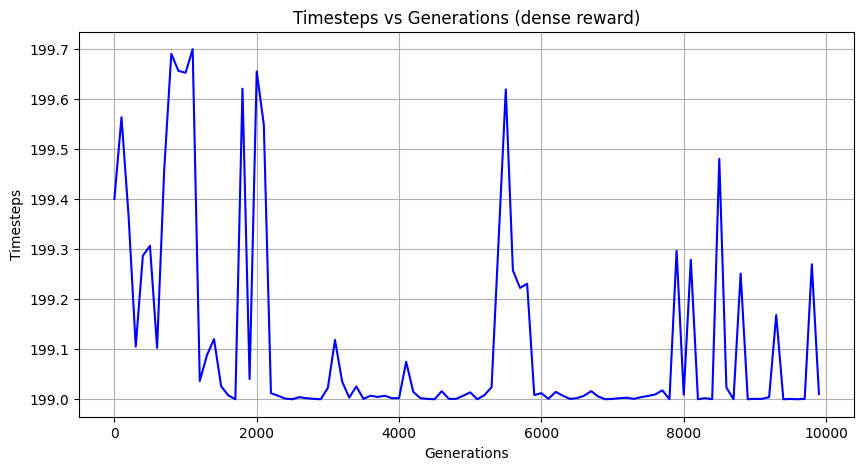

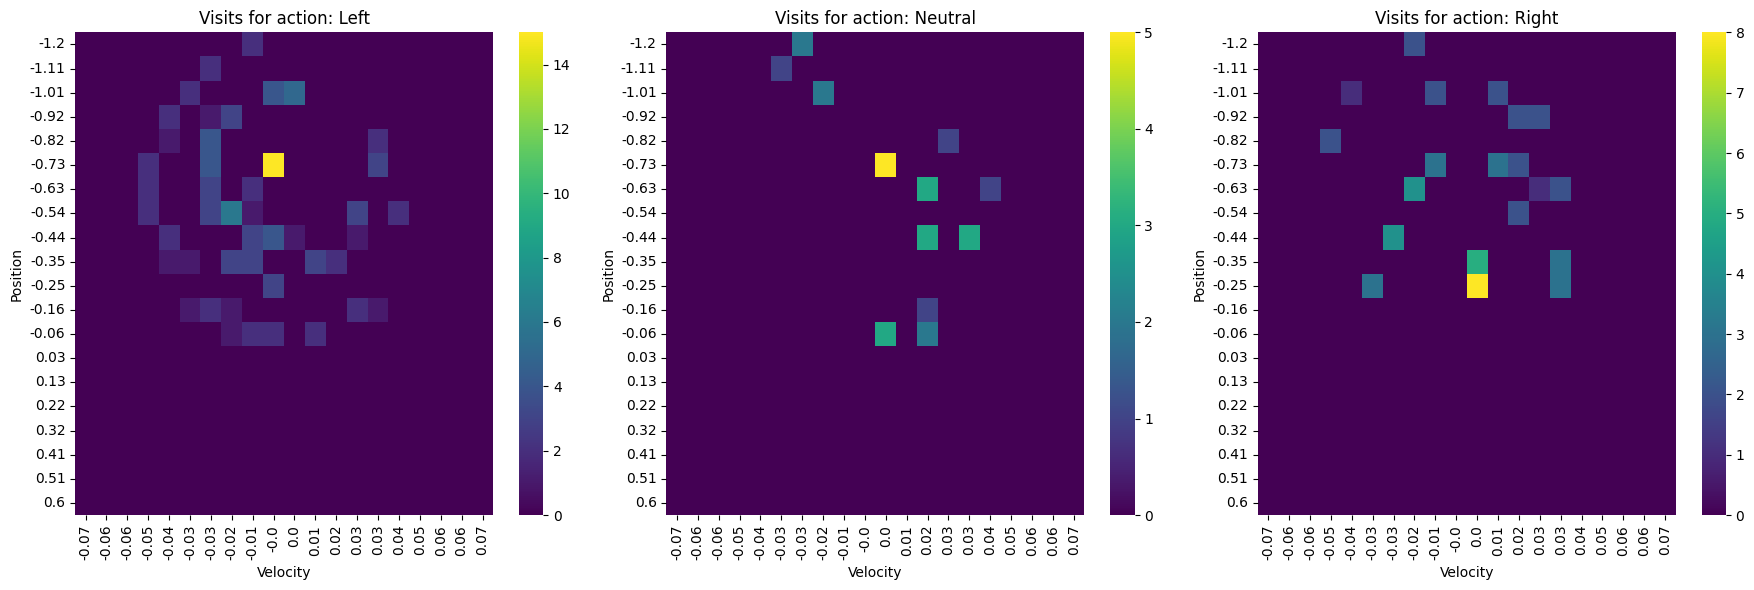

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [22]:
# Train and visualize the GA agent with dense reward
train_and_visualize_ga_agent(dense_reward, "dense")

  deprecation(

  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



Streaming output truncated to the last 5000 lines.
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.0000000000000013
reward:  -2.000000000

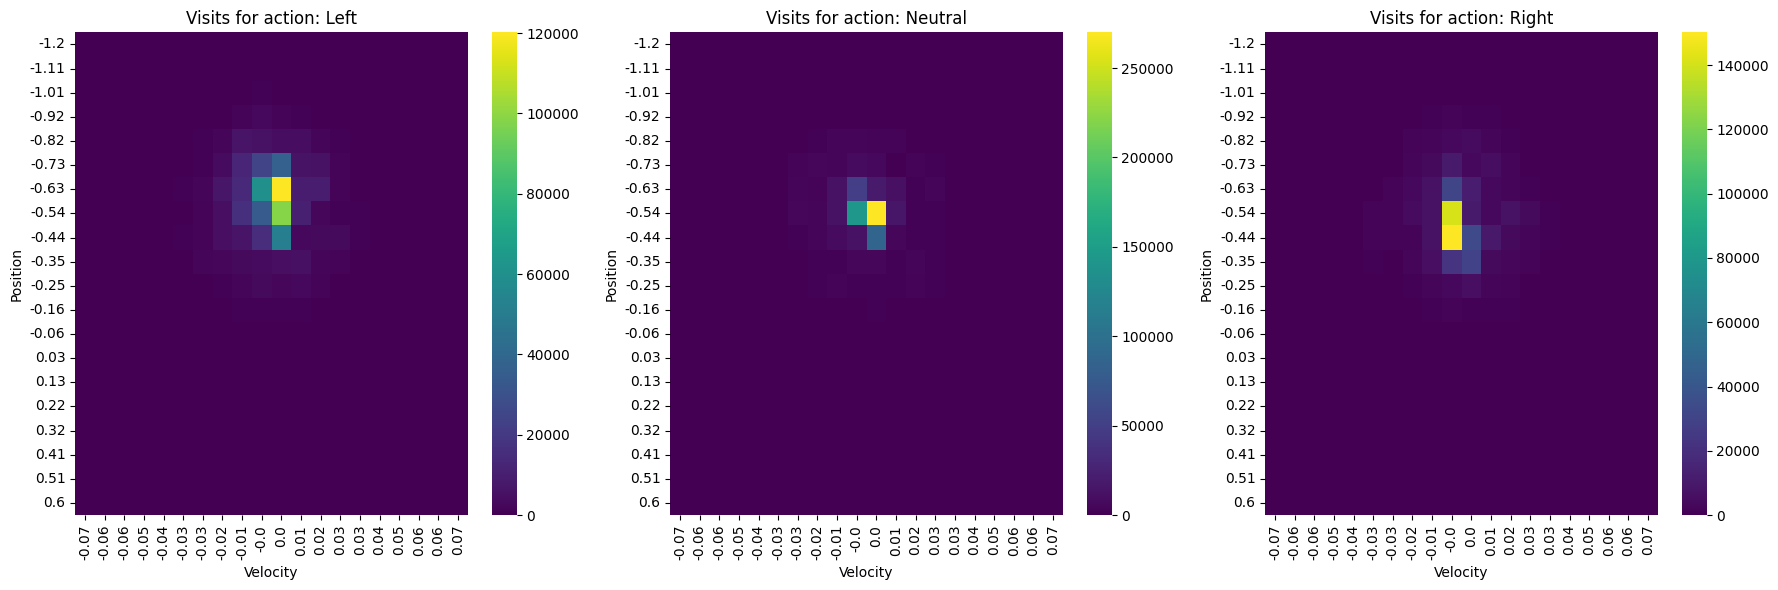

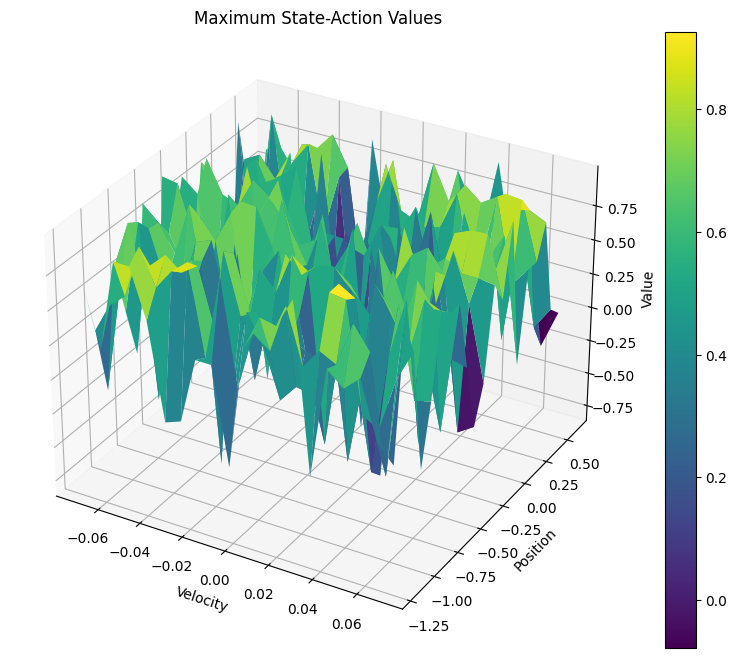

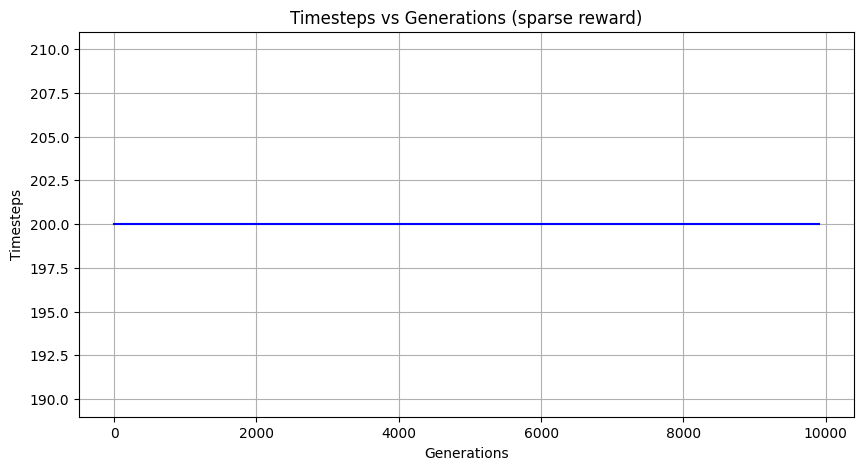

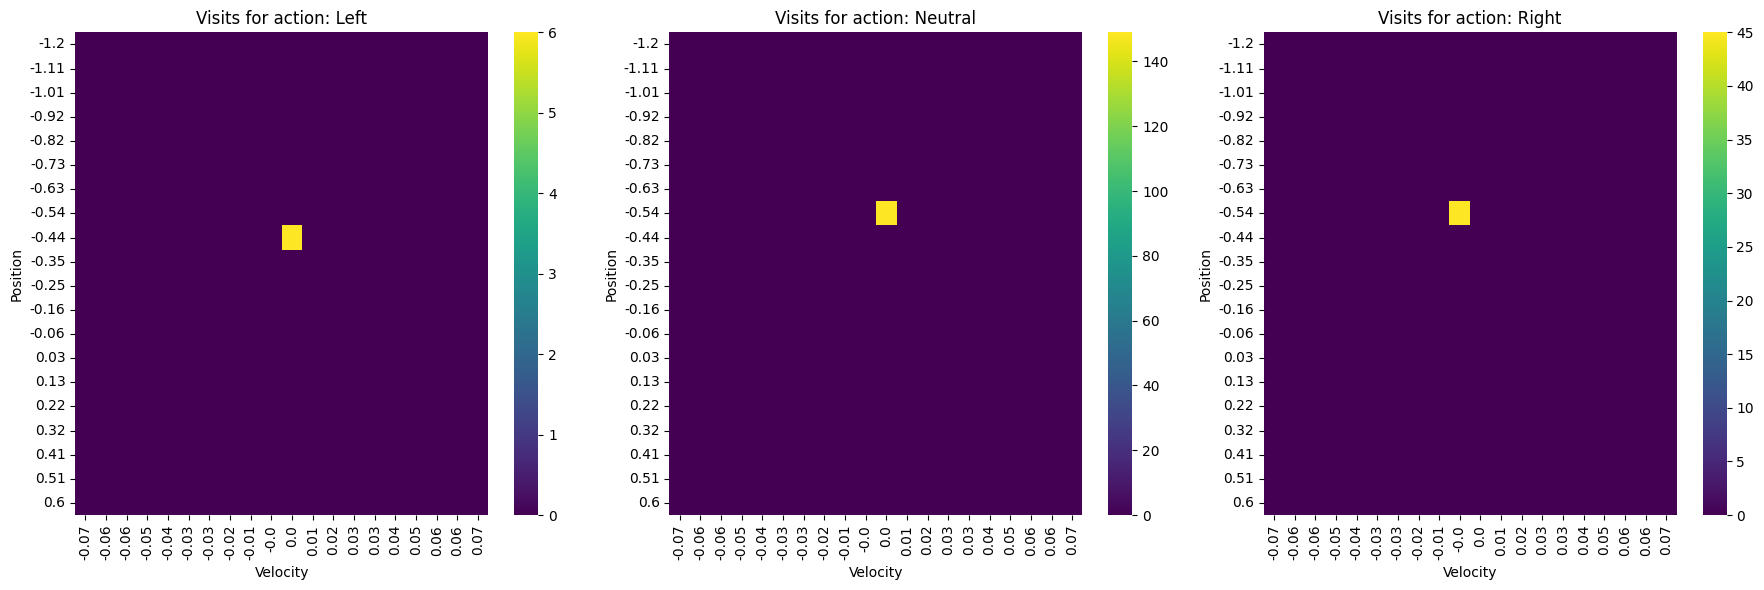

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [23]:
# Train and visualize the GA agent with custom sparse reward
train_and_visualize_ga_agent(custom_sparse_reward, "sparse")

# QL implementation without closest distance implementation

Episode 1 Average reward: -124.37681653433378, Average timesteps: nan
Episode 100 Average reward: -125.01689694457583, Average timesteps: 200.0
Episode 200 Average reward: -124.64651548036746, Average timesteps: 200.0
Episode 300 Average reward: -125.05158622490708, Average timesteps: 200.0
Episode 400 Average reward: -123.21628891390503, Average timesteps: 200.0
First clear on episode 478
Episode 500 Average reward: -120.21103940202532, Average timesteps: 200.0
Episode 600 Average reward: -120.06174007850412, Average timesteps: 170.0
Episode 700 Average reward: -118.19847501970155, Average timesteps: 200.0
Episode 800 Average reward: -115.18612574774434, Average timesteps: 200.0
Episode 900 Average reward: -117.53896210277497, Average timesteps: 168.0
Episode 1000 Average reward: -108.01697721930634, Average timesteps: 200.0
Episode 1100 Average reward: -110.35294400909504, Average timesteps: 154.0
Episode 1200 Average reward: -109.13584930155956, Average timesteps: 167.0
Episode 1300

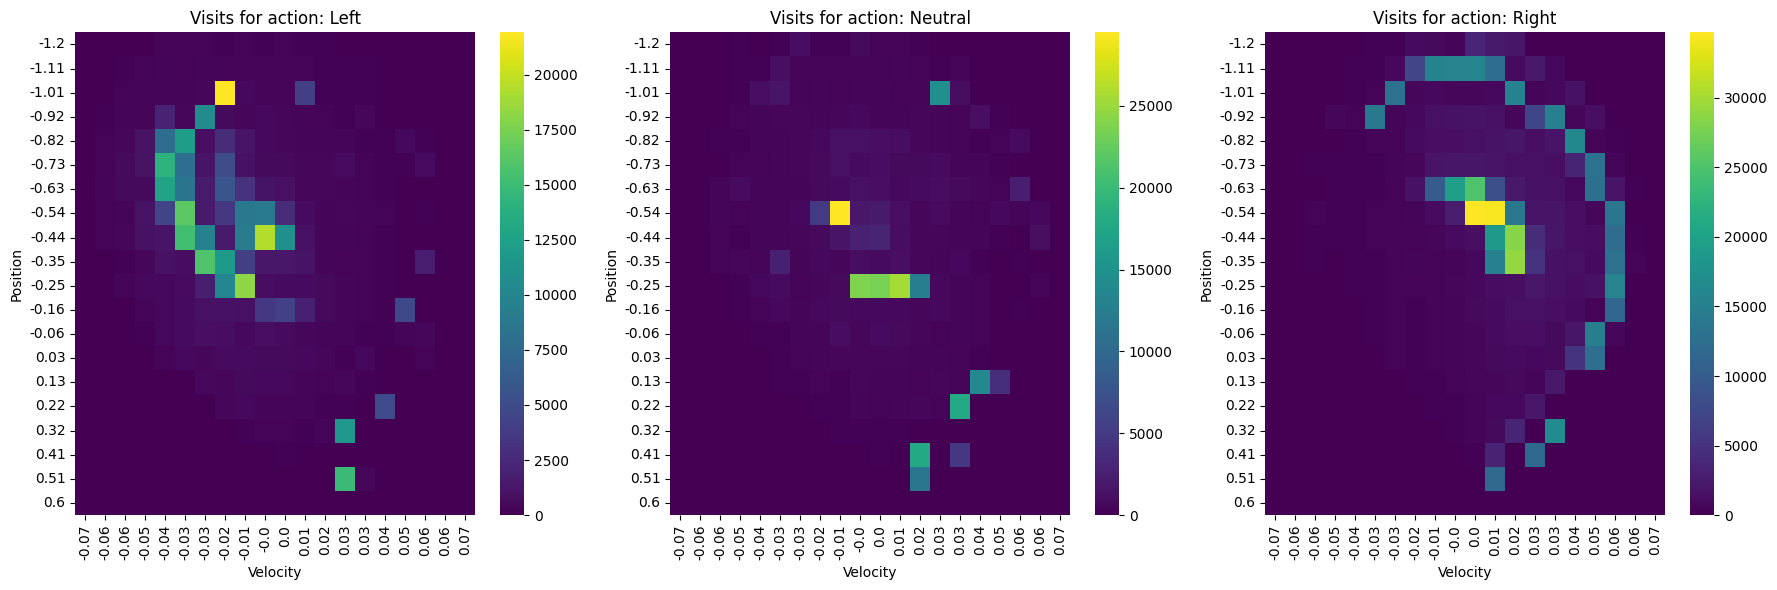

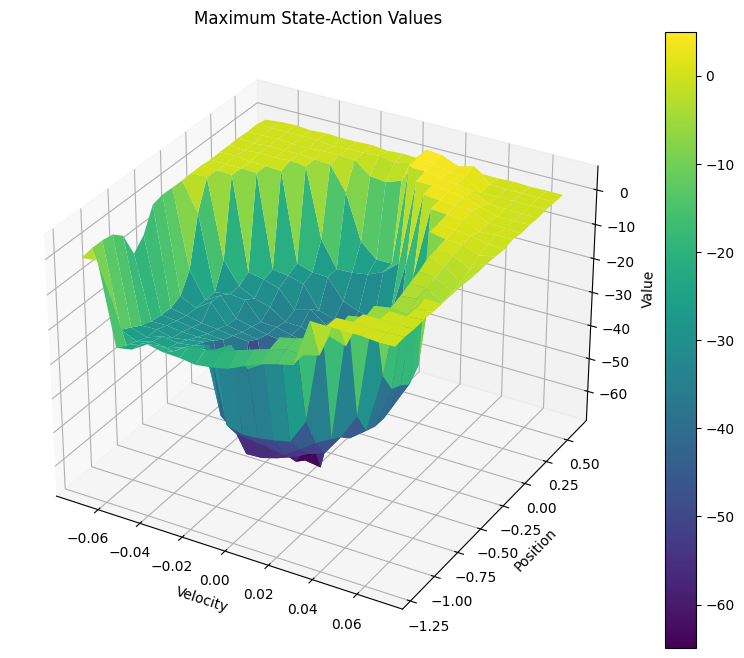

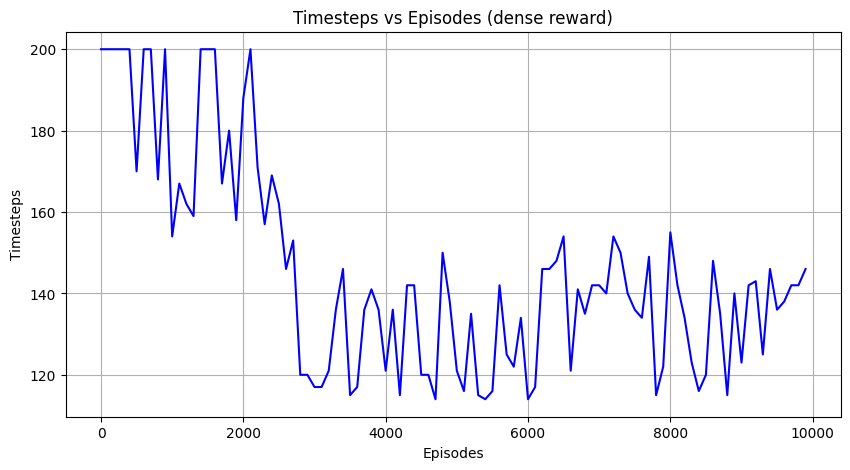

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -2.0000000000000013, Average timesteps: nan
Episode 100 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 200 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 300 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 400 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 500 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 600 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 700 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 800 Average reward: -2.000000000000001, Average timesteps: 200.0
First clear on episode 875
Episode 900 Average reward: -1.9885000000000008, Average timesteps: 200.0
Episode 1000 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 1100 Average reward: -1.8192000000000013, Average timesteps: 200.0
Episode 1200 Average reward: -1.8750000000000009, Average timesteps: 196.0
Episode 1300 Average 

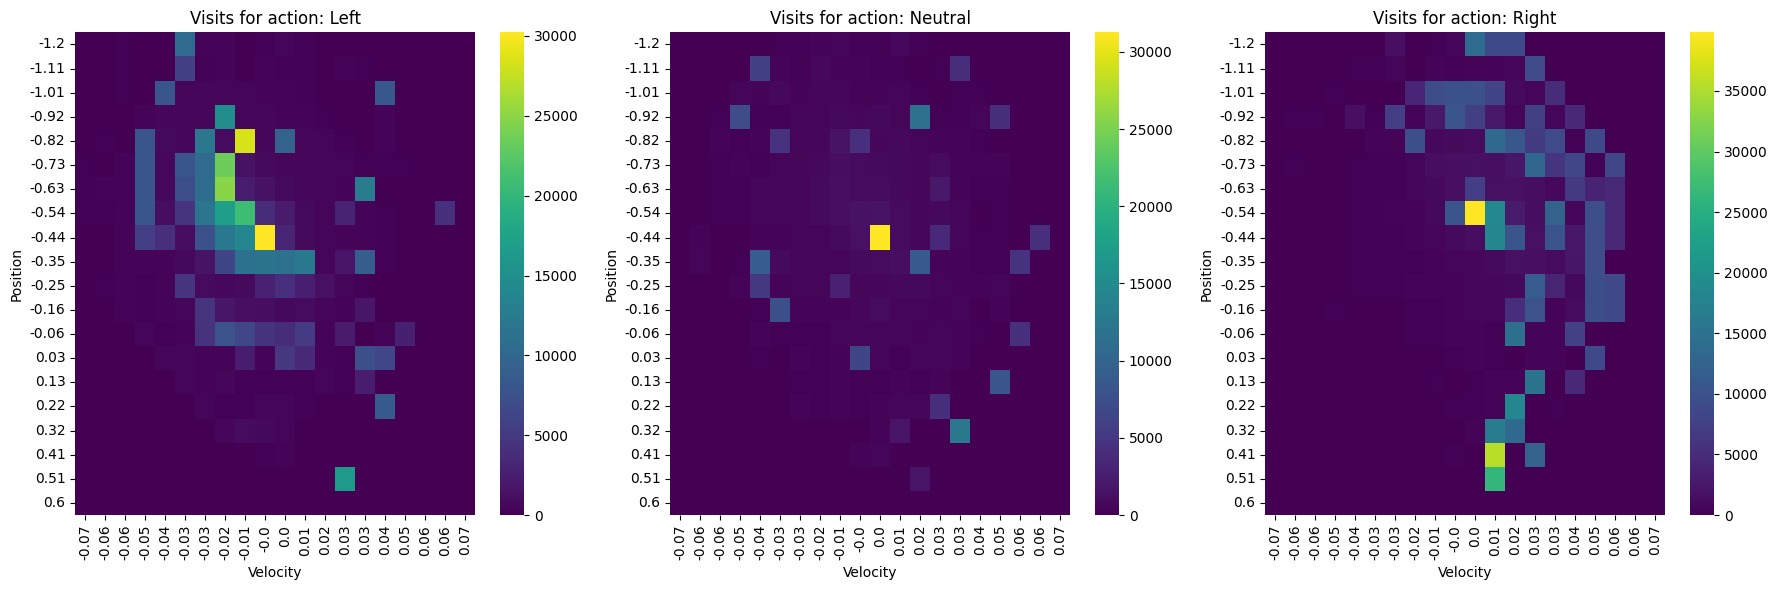

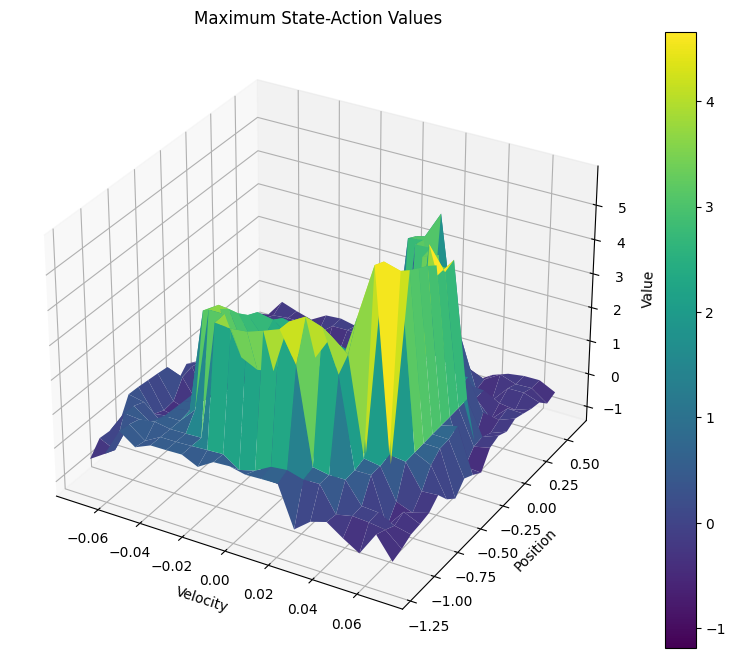

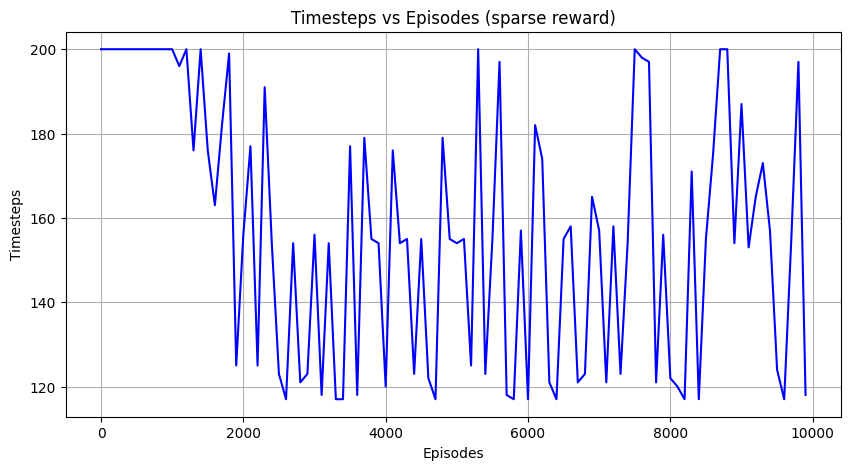

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [14]:
timesteps_dense, Qfinal_dense = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=dense_reward)

# Plot the timesteps obtained during training (dense reward)
plot_timesteps(timesteps_dense, 'Timesteps vs Episodes (dense reward)', 'Episodes')

# Visualize the Q-learning agent (dense reward)
HTML_video_qlearning_dense = watch_trained_agent(env, agent=Qfinal_dense, num_bins=(20, 20))
display(HTML_video_qlearning_dense)

# Train the Q-learning agent with custom sparse reward
timesteps_sparse, Qfinal_sparse = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=custom_sparse_reward)

# Plot the timesteps obtained during training (sparse reward)
plot_timesteps(timesteps_sparse, 'Timesteps vs Episodes (sparse reward)', 'Episodes')

# Visualize the Q-learning agent (sparse reward)
HTML_video_qlearning_sparse = watch_trained_agent(env, agent=Qfinal_sparse, num_bins=(20, 20))
display(HTML_video_qlearning_sparse)


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -123.00287682149148, Average timesteps: nan
Episode 100 Average reward: -125.30009331185788, Average timesteps: 200.0
Episode 200 Average reward: -124.50204511771393, Average timesteps: 200.0
Episode 300 Average reward: -124.274030730587, Average timesteps: 200.0
Episode 400 Average reward: -124.33597640882299, Average timesteps: 200.0
First clear on episode 417
Episode 500 Average reward: -120.90141813902054, Average timesteps: 200.0
Episode 600 Average reward: -117.29239096294266, Average timesteps: 200.0
Episode 700 Average reward: -121.25276920767811, Average timesteps: 200.0
Episode 800 Average reward: -109.41521391596415, Average timesteps: 193.0
Episode 900 Average reward: -107.82801726496258, Average timesteps: 181.0
Episode 1000 Average reward: -113.35807667921782, Average timesteps: 200.0
Episode 1100 Average reward: -112.60081324805535, Average timesteps: 200.0
Episode 1200 Average reward: -111.01413214051206, Average timesteps: 200.0
Episode 1300 A

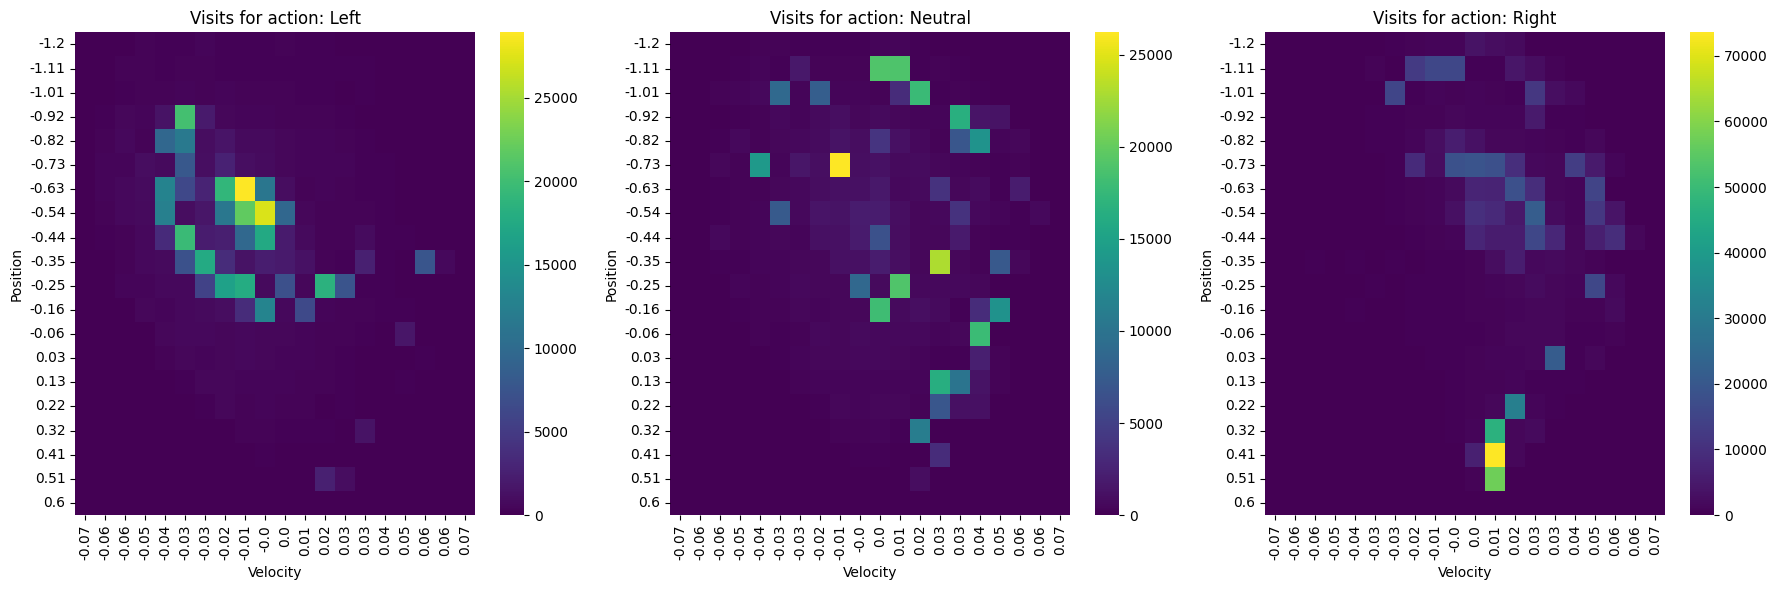

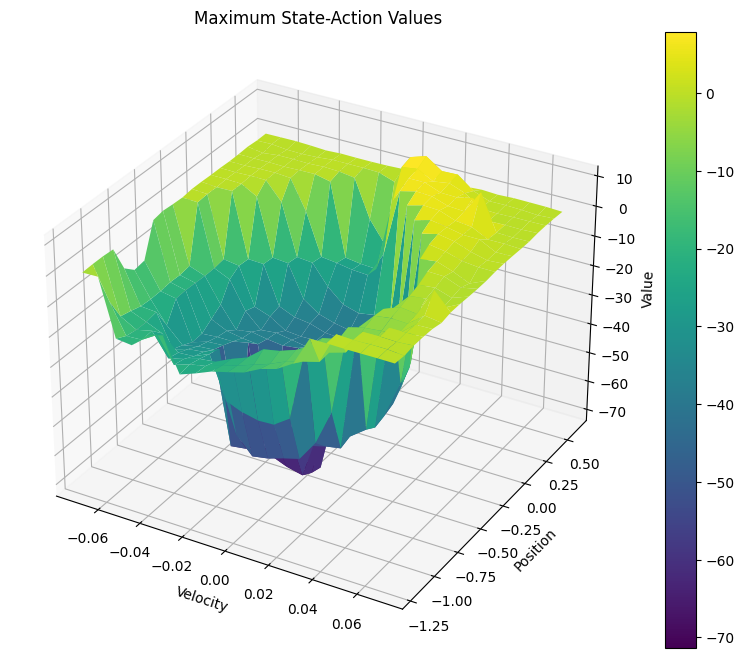

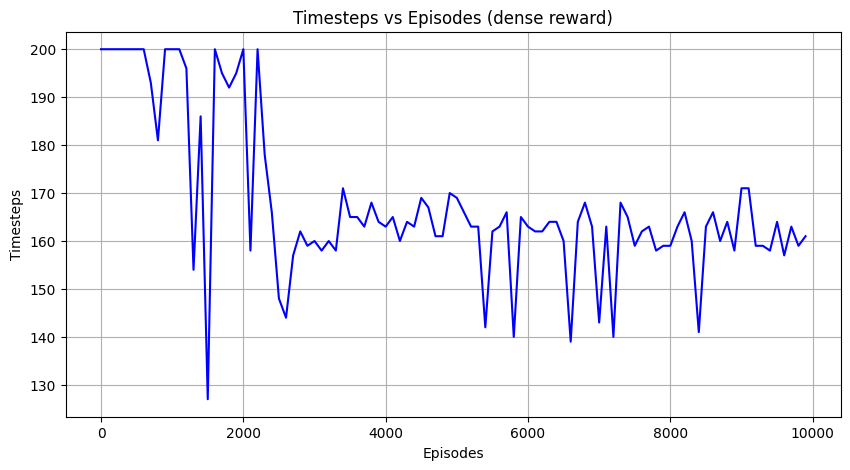

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -2.0000000000000013, Average timesteps: nan
Episode 100 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 200 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 300 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 400 Average reward: -2.000000000000001, Average timesteps: 200.0
First clear on episode 460
Episode 500 Average reward: -1.9759000000000009, Average timesteps: 200.0
Episode 600 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 700 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 800 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 900 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 1000 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 1100 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 1200 Average reward: -1.974500000000001, Average timesteps: 200.0
Episode 1300 Average re

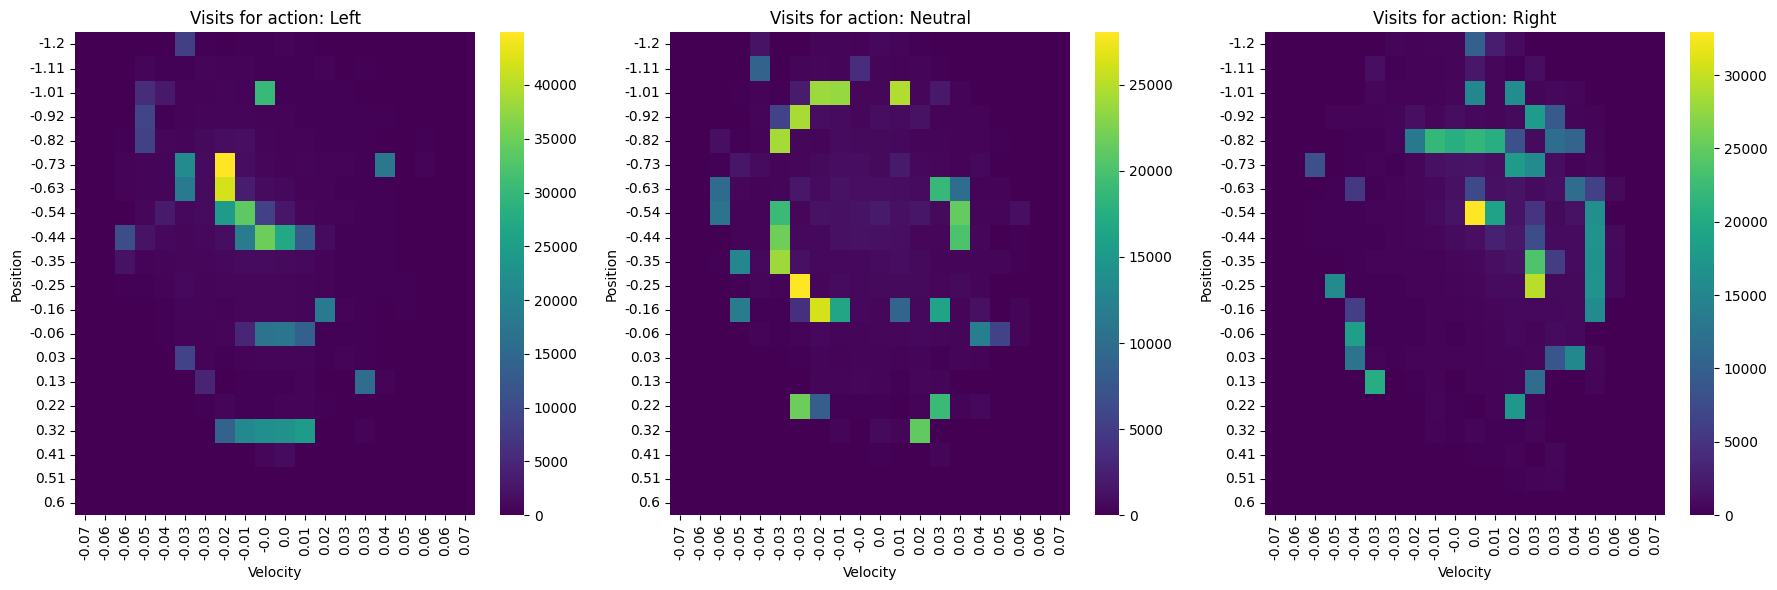

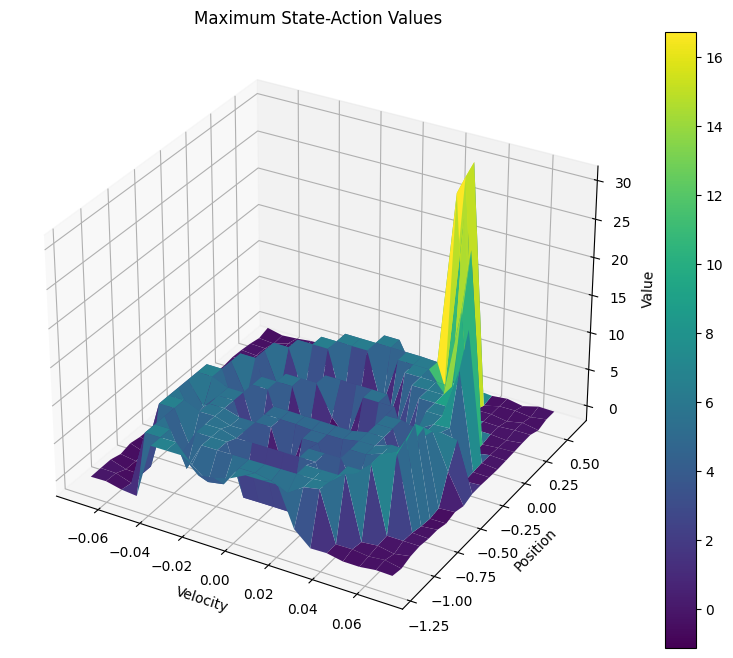

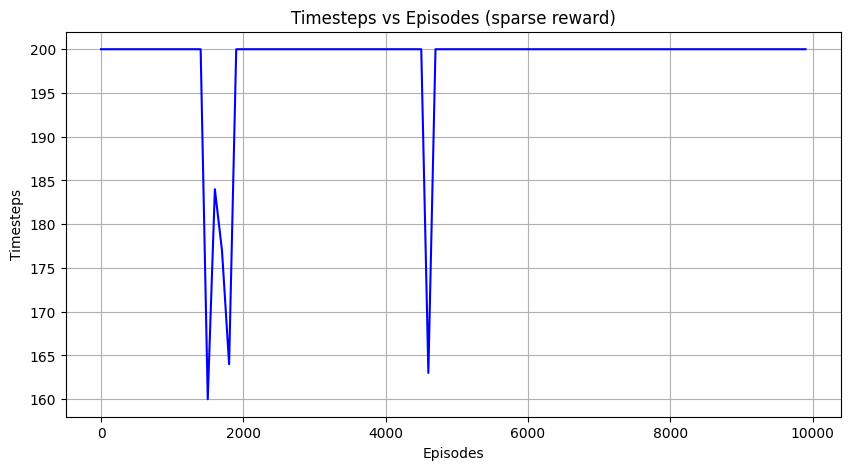

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [15]:
timesteps_dense, Qfinal_dense = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=dense_reward)

# Plot the timesteps obtained during training (dense reward)
plot_timesteps(timesteps_dense, 'Timesteps vs Episodes (dense reward)', 'Episodes')

# Visualize the Q-learning agent (dense reward)
HTML_video_qlearning_dense = watch_trained_agent(env, agent=Qfinal_dense, num_bins=(20, 20))
display(HTML_video_qlearning_dense)

# Train the Q-learning agent with custom sparse reward
timesteps_sparse, Qfinal_sparse = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=custom_sparse_reward)

# Plot the timesteps obtained during training (sparse reward)
plot_timesteps(timesteps_sparse, 'Timesteps vs Episodes (sparse reward)', 'Episodes')

# Visualize the Q-learning agent (sparse reward)
HTML_video_qlearning_sparse = watch_trained_agent(env, agent=Qfinal_sparse, num_bins=(20, 20))
display(HTML_video_qlearning_sparse)

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -123.64673852920528, Average timesteps: nan
Episode 100 Average reward: -125.01421094896894, Average timesteps: 200.0
Episode 200 Average reward: -124.7666119472468, Average timesteps: 200.0
Episode 300 Average reward: -124.59791634792505, Average timesteps: 200.0
Episode 400 Average reward: -123.99768378226952, Average timesteps: 200.0
First clear on episode 422
Episode 500 Average reward: -123.30885194137701, Average timesteps: 200.0
Episode 600 Average reward: -119.00675877007566, Average timesteps: 200.0
Episode 700 Average reward: -114.02883062419947, Average timesteps: 200.0
Episode 800 Average reward: -118.01893215956386, Average timesteps: 160.0
Episode 900 Average reward: -119.66046231602255, Average timesteps: 200.0
Episode 1000 Average reward: -113.44483895301481, Average timesteps: 200.0
Episode 1100 Average reward: -108.93953446186646, Average timesteps: 197.0
Episode 1200 Average reward: -102.8092131947239, Average timesteps: 195.0
Episode 1300 A

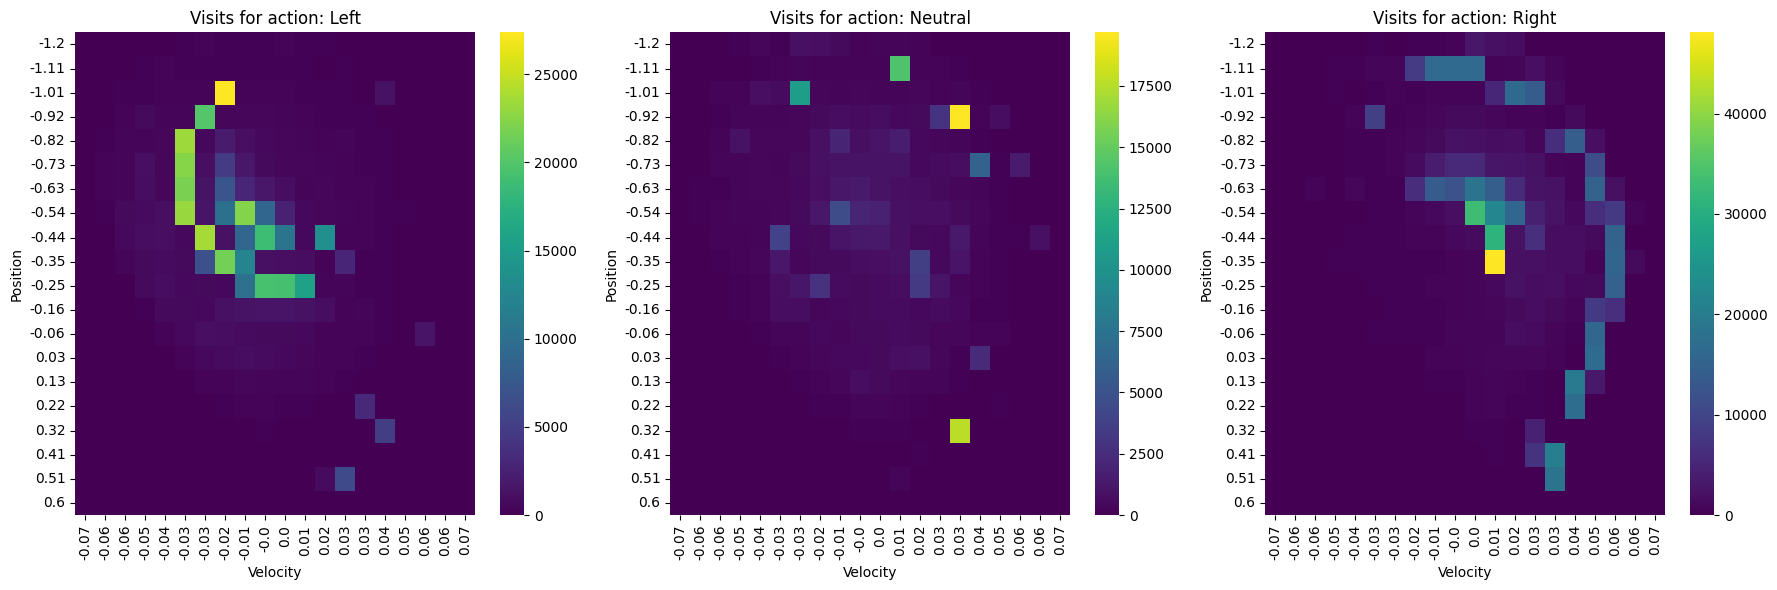

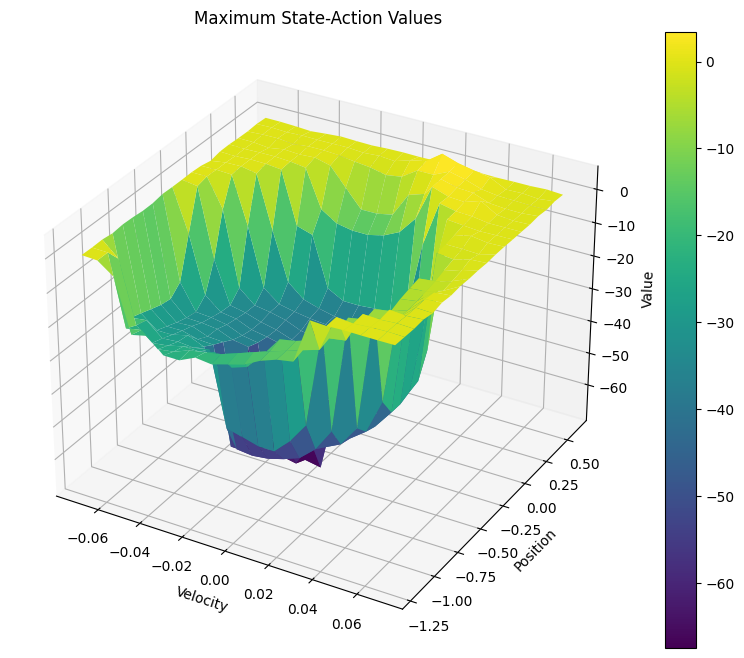

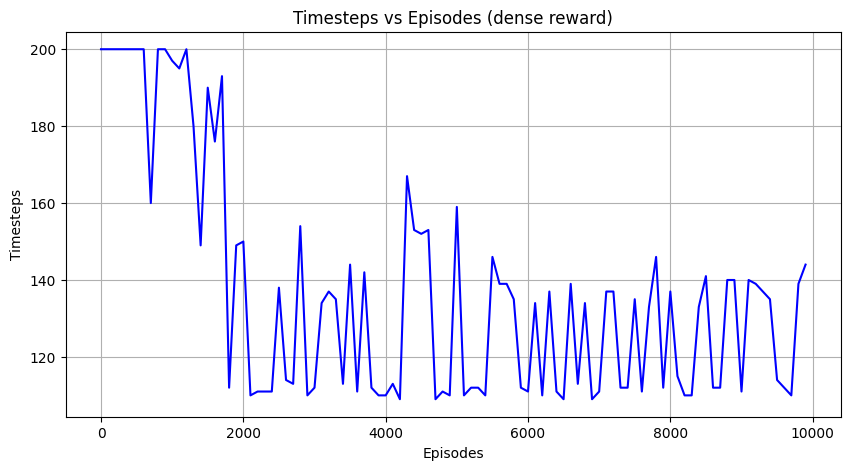

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -2.0000000000000013, Average timesteps: nan
Episode 100 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 200 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 300 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 400 Average reward: -2.000000000000001, Average timesteps: 200.0
First clear on episode 458
Episode 500 Average reward: -1.9873000000000007, Average timesteps: 200.0
Episode 600 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 700 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 800 Average reward: -1.987500000000001, Average timesteps: 200.0
Episode 900 Average reward: -2.000000000000001, Average timesteps: 200.0
Episode 1000 Average reward: -1.8758000000000012, Average timesteps: 181.0
Episode 1100 Average reward: -1.838300000000001, Average timesteps: 200.0
Episode 1200 Average reward: -1.734100000000001, Average timesteps: 165.0
Episode 1300 Average r

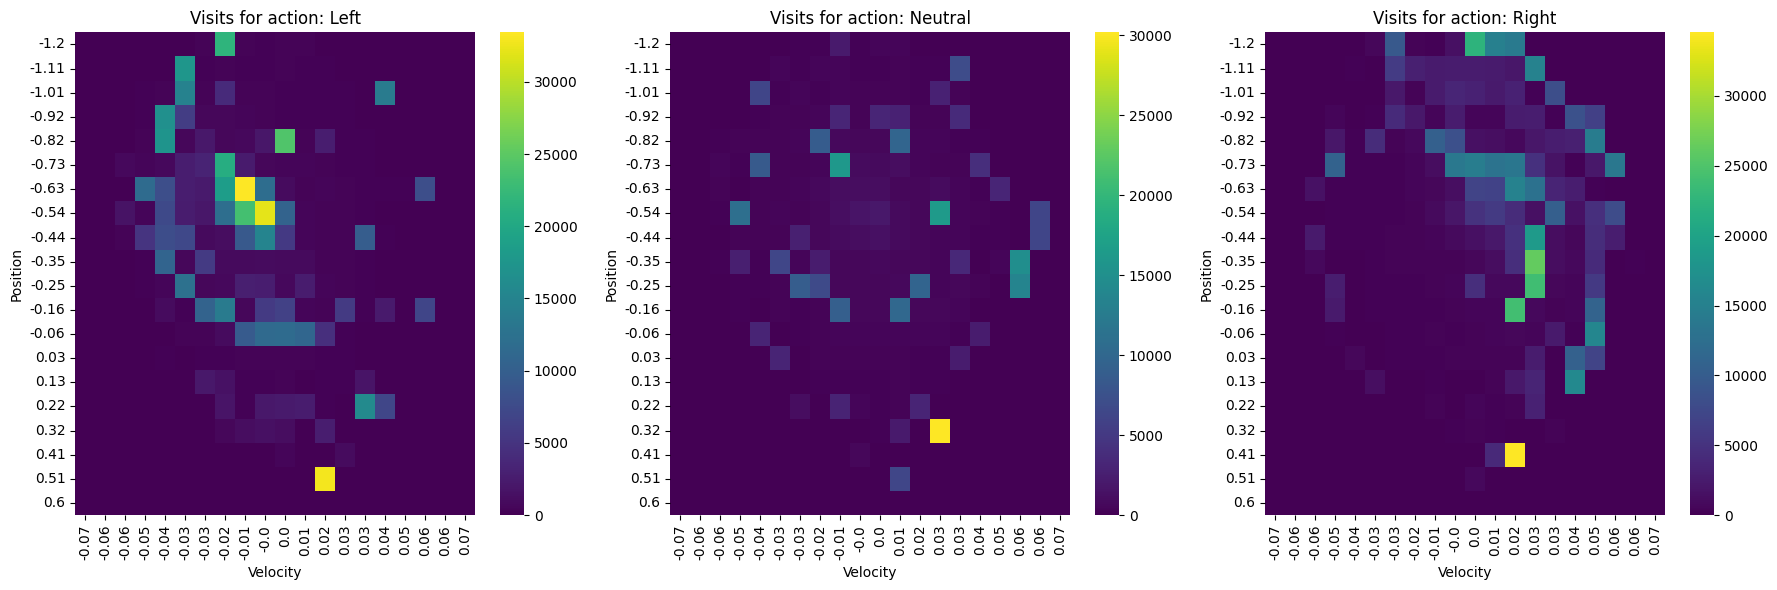

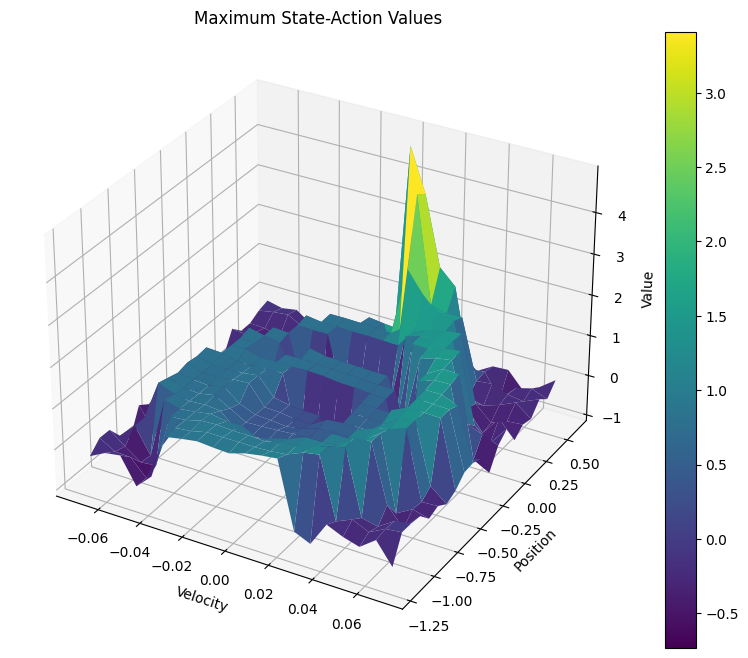

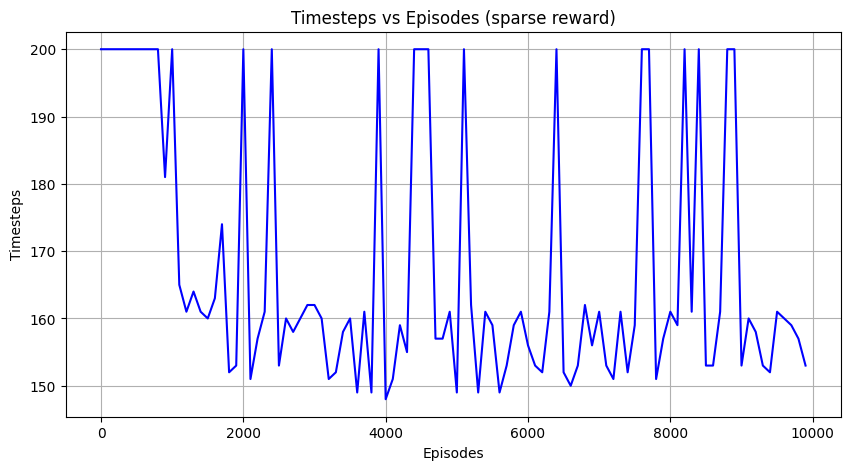

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [24]:
timesteps_dense, Qfinal_dense = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=dense_reward)

# Plot the timesteps obtained during training (dense reward)
plot_timesteps(timesteps_dense, 'Timesteps vs Episodes (dense reward)', 'Episodes')

# Visualize the Q-learning agent (dense reward)
HTML_video_qlearning_dense = watch_trained_agent(env, agent=Qfinal_dense, num_bins=(20, 20))
display(HTML_video_qlearning_dense)

# Train the Q-learning agent with custom sparse reward
timesteps_sparse, Qfinal_sparse = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=custom_sparse_reward)

# Plot the timesteps obtained during training (sparse reward)
plot_timesteps(timesteps_sparse, 'Timesteps vs Episodes (sparse reward)', 'Episodes')

# Visualize the Q-learning agent (sparse reward)
HTML_video_qlearning_sparse = watch_trained_agent(env, agent=Qfinal_sparse, num_bins=(20, 20))
display(HTML_video_qlearning_sparse)

## QL Implementation with closest distance implementation

  if not isinstance(terminated, (bool, np.bool8)):

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -327.2832710146903, Average timesteps: nan
Episode 100 Average reward: -324.3071581788526, Average timesteps: 200.0
Episode 200 Average reward: -307.3818235467429, Average timesteps: 200.0
Episode 300 Average reward: -301.100846754728, Average timesteps: 200.0
Episode 400 Average reward: -296.0462178122998, Average timesteps: 200.0
Episode 500 Average reward: -279.63656612737213, Average timesteps: 200.0
First clear on episode 561
Episode 600 Average reward: -262.79335552215923, Average timesteps: 174.0
Episode 700 Average reward: -258.7635080018093, Average timesteps: 200.0
Episode 800 Average reward: -265.49541524892027, Average timesteps: 200.0
Episode 900 Average reward: -265.76496805133183, Average timesteps: 200.0
Episode 1000 Average reward: -254.37950616255551, Average timesteps: 200.0
Episode 1100 Average reward: -258.1565390749212, Average timesteps: 156.0
Episode 1200 Average reward: -232.7689822447093, Average timesteps: 200.0
Episode 1300 Average 

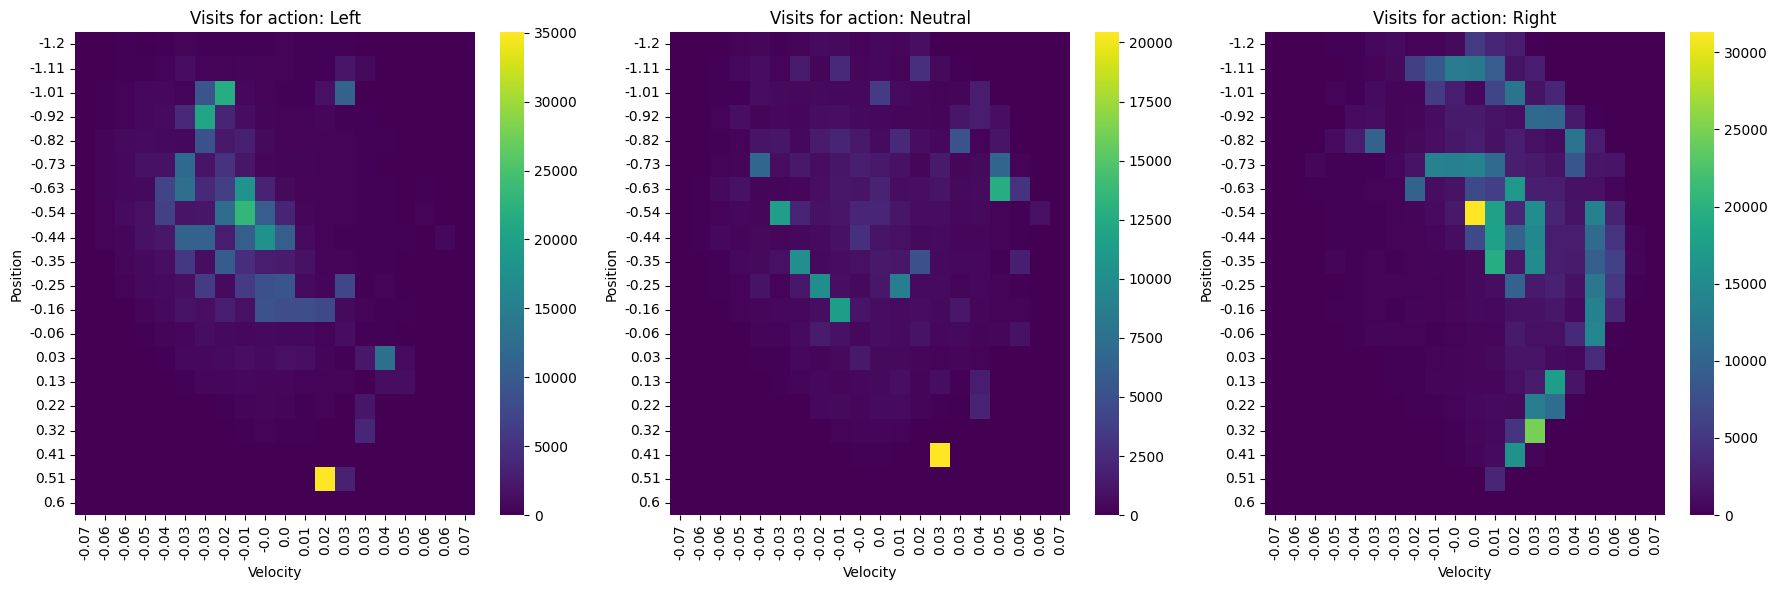

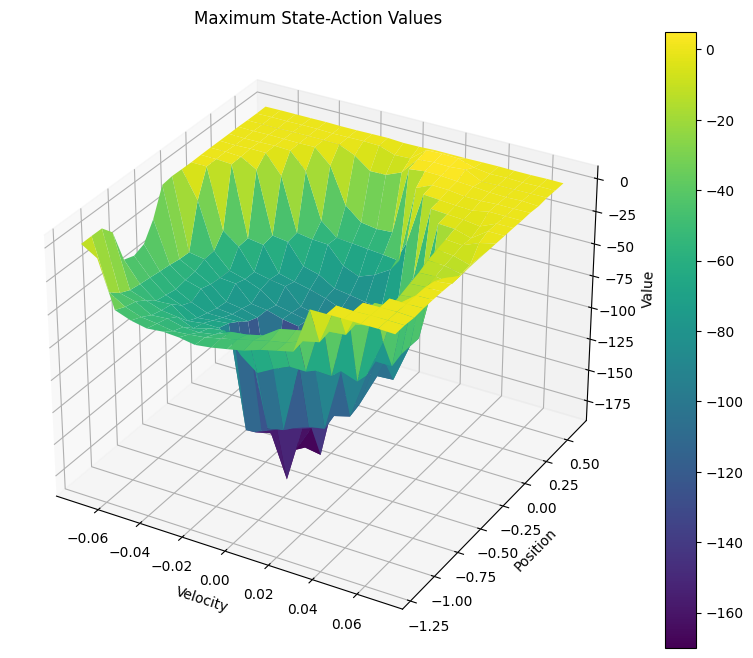

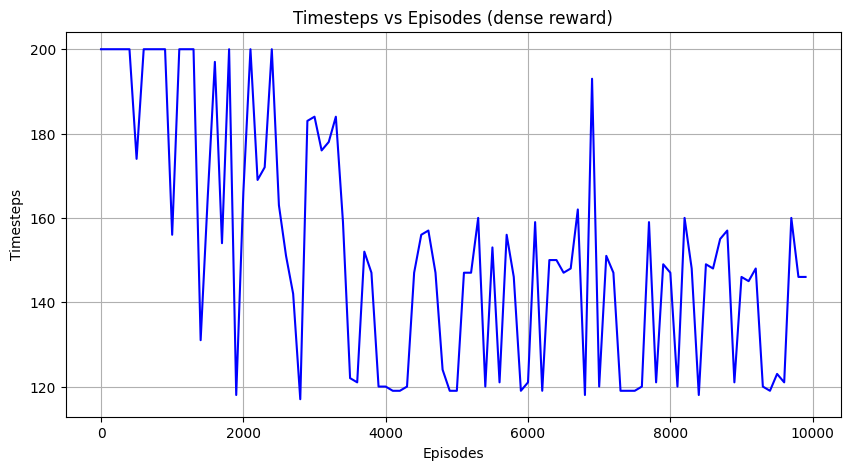

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -198.90593743324374, Average timesteps: nan
Episode 100 Average reward: -199.94833698909824, Average timesteps: 200.0
Episode 200 Average reward: -185.168043384724, Average timesteps: 200.0
Episode 300 Average reward: -173.98767895295154, Average timesteps: 200.0
Episode 400 Average reward: -172.66505606364393, Average timesteps: 200.0
First clear on episode 481
Episode 500 Average reward: -157.88456789506006, Average timesteps: 200.0
Episode 600 Average reward: -157.59973911815956, Average timesteps: 200.0
Episode 700 Average reward: -151.46148043460414, Average timesteps: 200.0
Episode 800 Average reward: -154.99685282081725, Average timesteps: 200.0
Episode 900 Average reward: -132.11389336112563, Average timesteps: 195.0
Episode 1000 Average reward: -133.6900309754484, Average timesteps: 162.0
Episode 1100 Average reward: -136.0397938886466, Average timesteps: 164.0
Episode 1200 Average reward: -134.54557814663377, Average timesteps: 178.0
Episode 1300 Ave

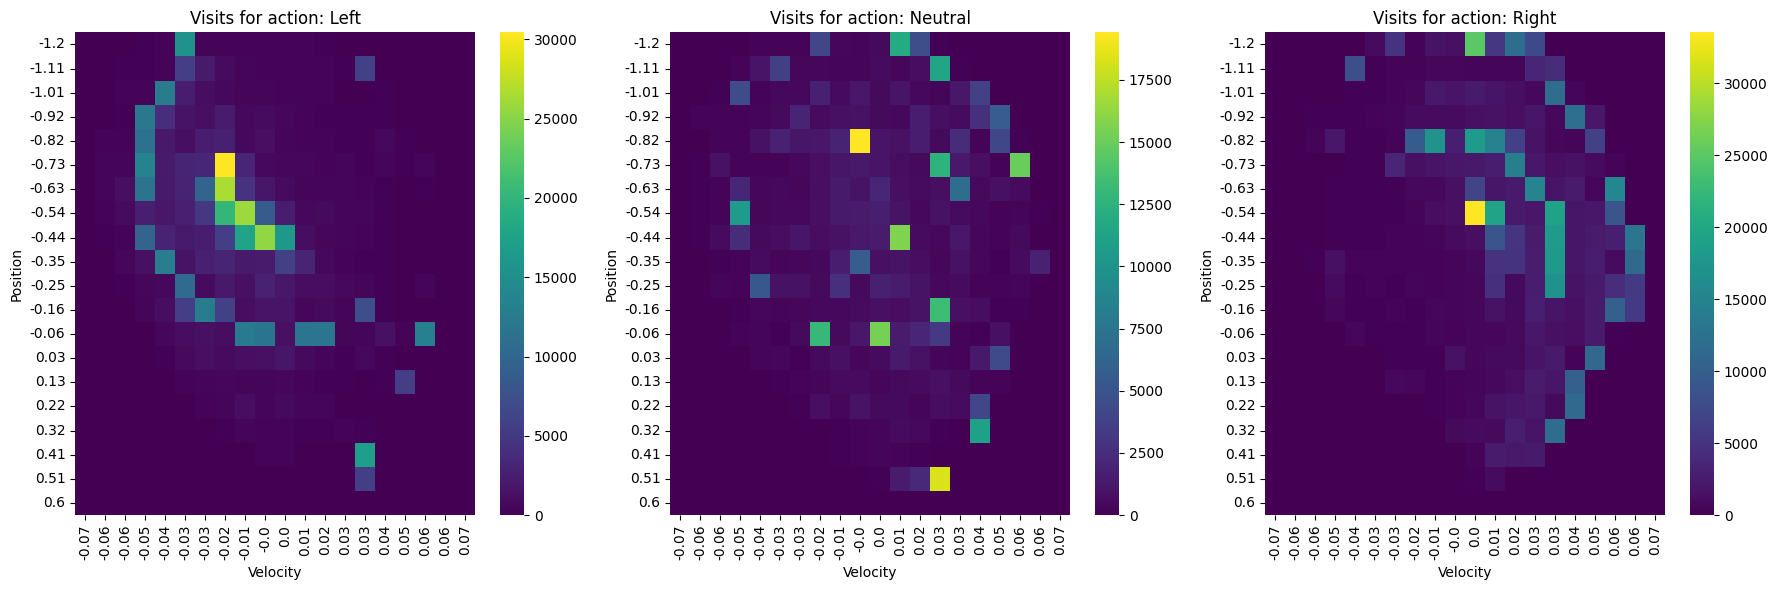

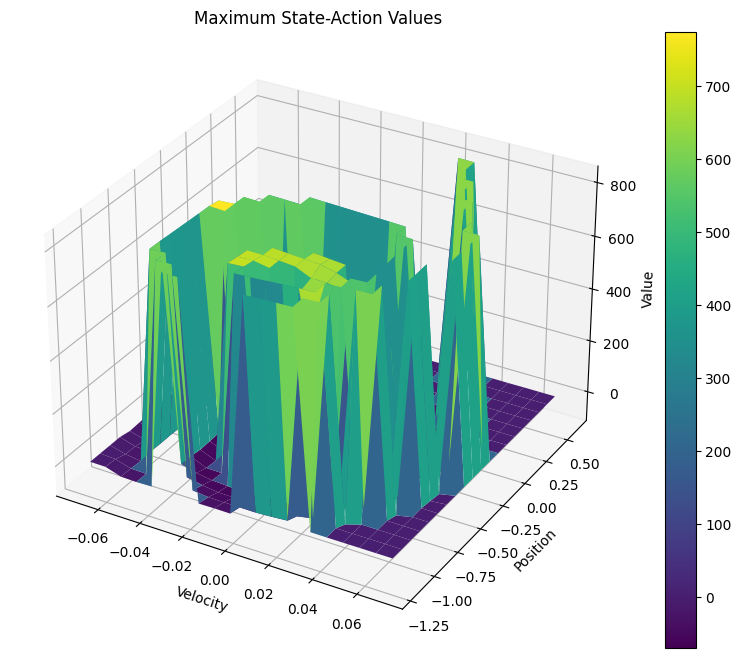

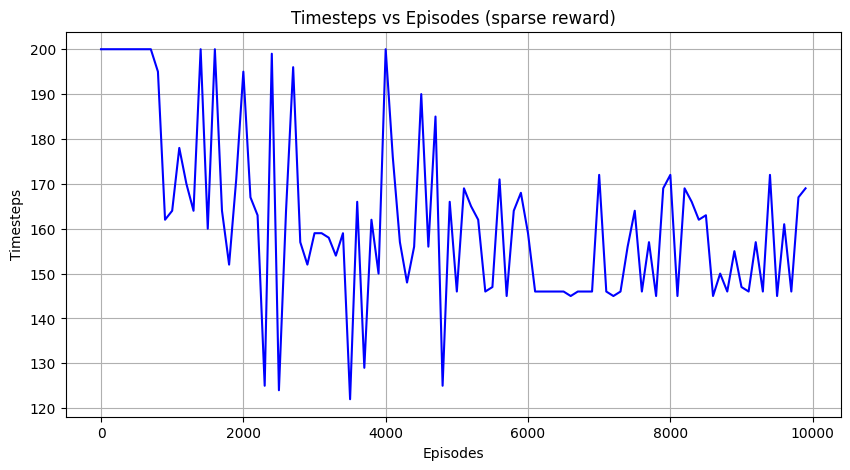

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [26]:
timesteps_dense, Qfinal_dense = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=dense_reward)

# Plot the timesteps obtained during training (dense reward)
plot_timesteps(timesteps_dense, 'Timesteps vs Episodes (dense reward)', 'Episodes')

# Visualize the Q-learning agent (dense reward)
HTML_video_qlearning_dense = watch_trained_agent(env, agent=Qfinal_dense, num_bins=(20, 20))
display(HTML_video_qlearning_dense)

# Train the Q-learning agent with custom sparse reward
timesteps_sparse, Qfinal_sparse = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=custom_sparse_reward)

# Plot the timesteps obtained during training (sparse reward)
plot_timesteps(timesteps_sparse, 'Timesteps vs Episodes (sparse reward)', 'Episodes')

# Visualize the Q-learning agent (sparse reward)
HTML_video_qlearning_sparse = watch_trained_agent(env, agent=Qfinal_sparse, num_bins=(20, 20))
display(HTML_video_qlearning_sparse)

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -317.29755092826156, Average timesteps: nan
Episode 100 Average reward: -322.51766301990745, Average timesteps: 200.0
Episode 200 Average reward: -306.9041520307516, Average timesteps: 200.0
Episode 300 Average reward: -292.8769418342857, Average timesteps: 200.0
Episode 400 Average reward: -290.43221334986924, Average timesteps: 200.0
First clear on episode 424
Episode 500 Average reward: -279.3933667087557, Average timesteps: 200.0
Episode 600 Average reward: -281.82143683448936, Average timesteps: 173.0
Episode 700 Average reward: -267.47048631967886, Average timesteps: 200.0
Episode 800 Average reward: -267.53055287617354, Average timesteps: 200.0
Episode 900 Average reward: -250.92926818011722, Average timesteps: 174.0
Episode 1000 Average reward: -243.29513736118028, Average timesteps: 163.0
Episode 1100 Average reward: -243.97468663037998, Average timesteps: 191.0
Episode 1200 Average reward: -228.03651683033618, Average timesteps: 185.0
Episode 1300 Av

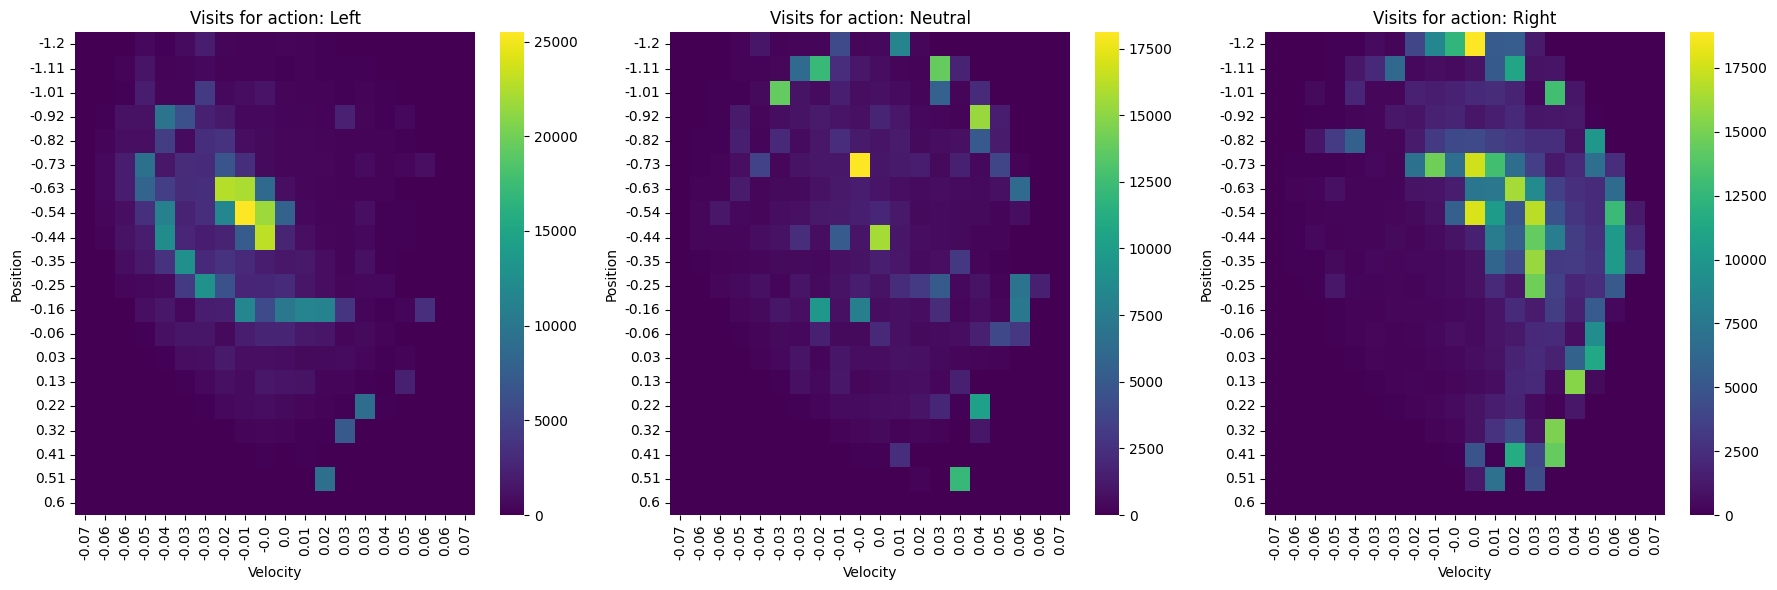

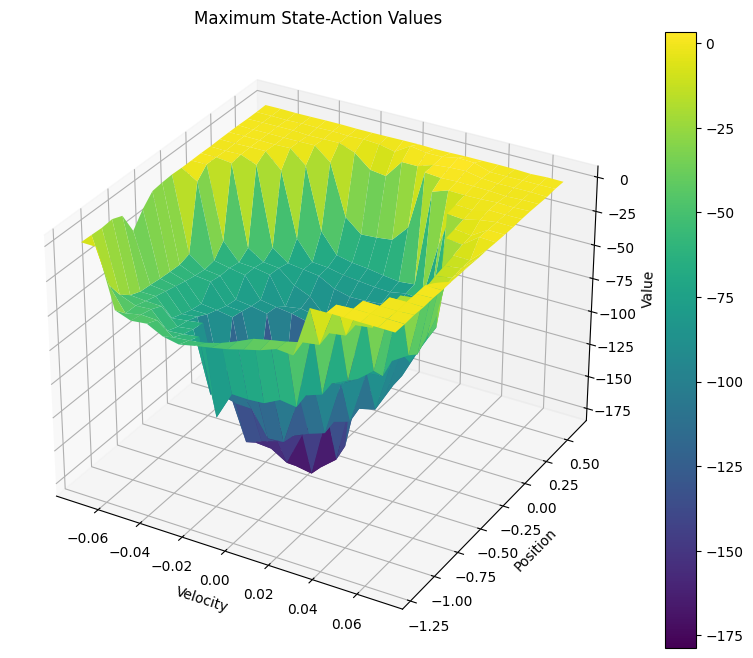

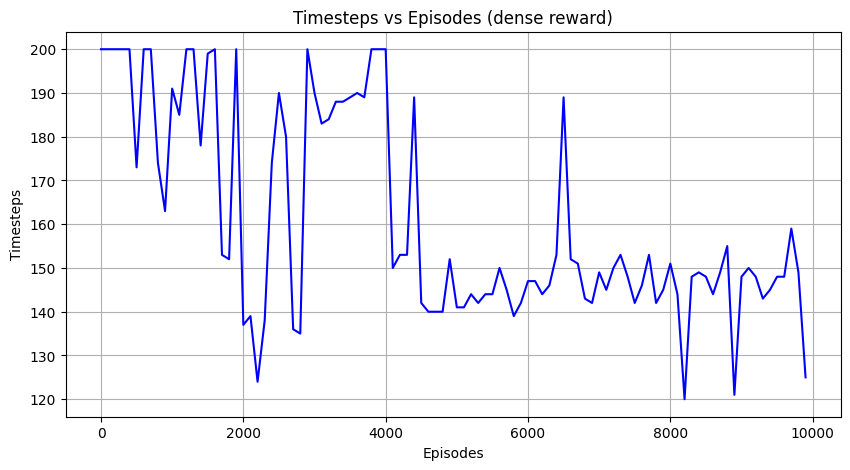

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -220.58957892656437, Average timesteps: nan
Episode 100 Average reward: -198.60301600113607, Average timesteps: 200.0
Episode 200 Average reward: -183.20383717527875, Average timesteps: 200.0
Episode 300 Average reward: -180.96176398083858, Average timesteps: 200.0
Episode 400 Average reward: -162.7526660253189, Average timesteps: 200.0
First clear on episode 452
Episode 500 Average reward: -167.0151098143963, Average timesteps: 200.0
Episode 600 Average reward: -160.36638503743947, Average timesteps: 200.0
Episode 700 Average reward: -154.49655928555163, Average timesteps: 200.0
Episode 800 Average reward: -144.12477966222997, Average timesteps: 200.0
Episode 900 Average reward: -136.17532743348116, Average timesteps: 200.0
Episode 1000 Average reward: -147.60939228286924, Average timesteps: 200.0
Episode 1100 Average reward: -143.31929901524177, Average timesteps: 159.0
Episode 1200 Average reward: -129.91293301779598, Average timesteps: 177.0
Episode 1300 A

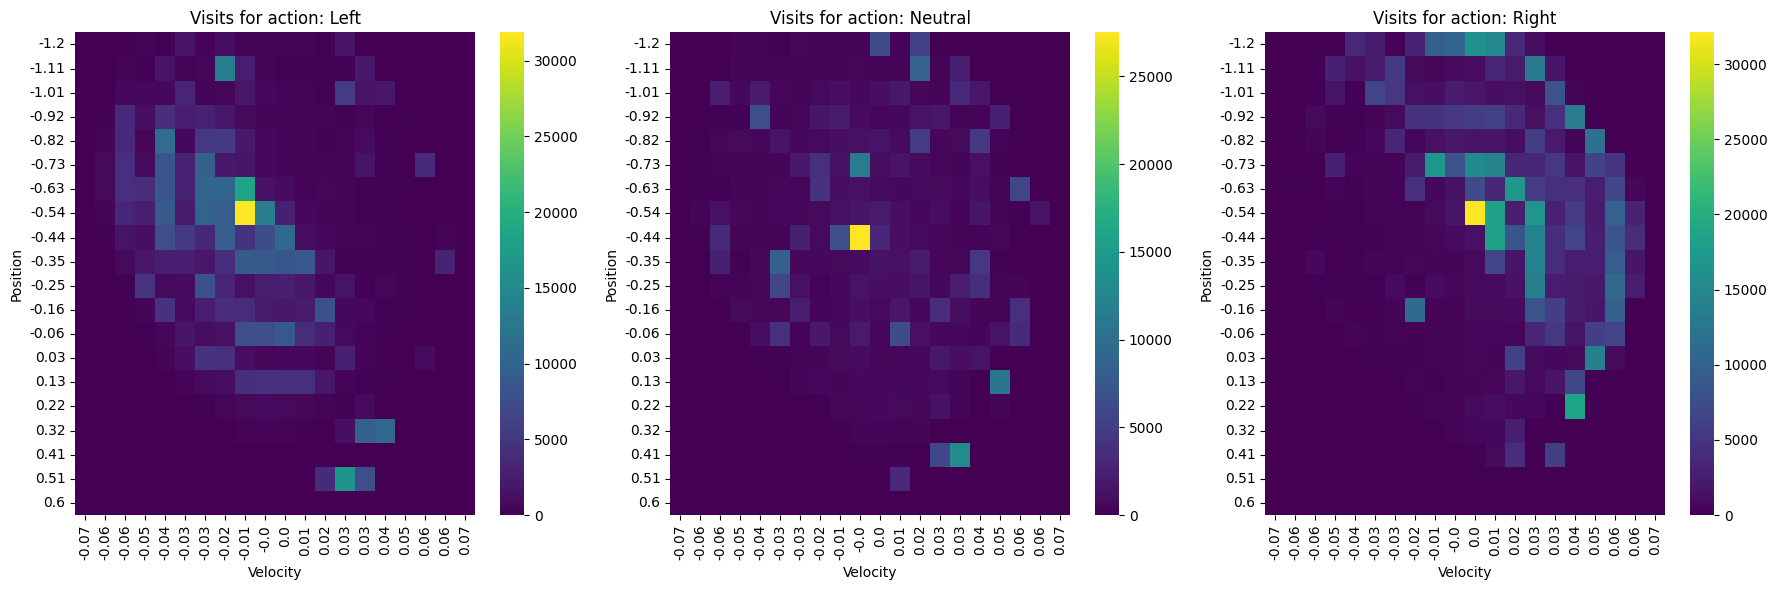

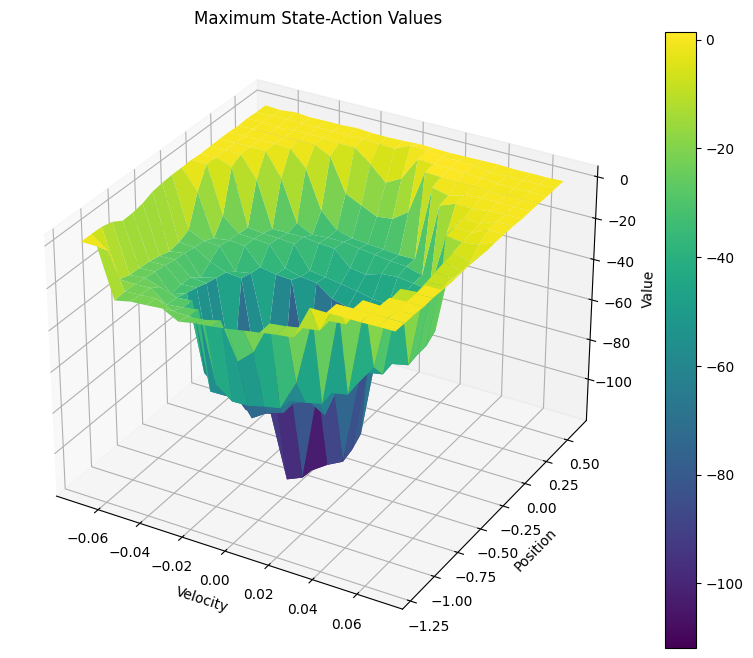

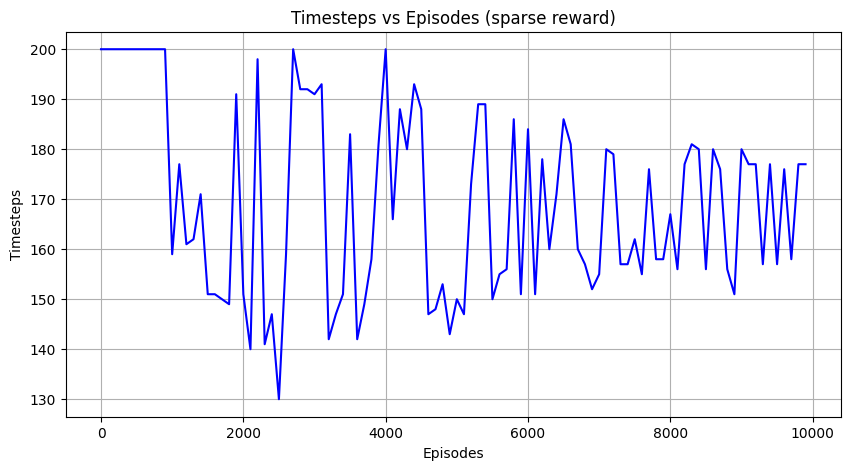

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [27]:
timesteps_dense, Qfinal_dense = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=dense_reward)

# Plot the timesteps obtained during training (dense reward)
plot_timesteps(timesteps_dense, 'Timesteps vs Episodes (dense reward)', 'Episodes')

# Visualize the Q-learning agent (dense reward)
HTML_video_qlearning_dense = watch_trained_agent(env, agent=Qfinal_dense, num_bins=(20, 20))
display(HTML_video_qlearning_dense)

# Train the Q-learning agent with custom sparse reward
timesteps_sparse, Qfinal_sparse = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=custom_sparse_reward)

# Plot the timesteps obtained during training (sparse reward)
plot_timesteps(timesteps_sparse, 'Timesteps vs Episodes (sparse reward)', 'Episodes')

# Visualize the Q-learning agent (sparse reward)
HTML_video_qlearning_sparse = watch_trained_agent(env, agent=Qfinal_sparse, num_bins=(20, 20))
display(HTML_video_qlearning_sparse)

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -321.7856693300938, Average timesteps: nan
Episode 100 Average reward: -321.32404676123326, Average timesteps: 200.0
Episode 200 Average reward: -305.20661312896215, Average timesteps: 200.0
Episode 300 Average reward: -295.00523189344347, Average timesteps: 200.0
First clear on episode 386
Episode 400 Average reward: -284.6562410782454, Average timesteps: 200.0
Episode 500 Average reward: -284.3127662240249, Average timesteps: 200.0
Episode 600 Average reward: -279.7869753888875, Average timesteps: 198.0
Episode 700 Average reward: -259.98880740918656, Average timesteps: 200.0
Episode 800 Average reward: -257.4178543455427, Average timesteps: 157.0
Episode 900 Average reward: -242.6779967202642, Average timesteps: 156.0
Episode 1000 Average reward: -231.3063482065413, Average timesteps: 200.0
Episode 1100 Average reward: -229.45290614683498, Average timesteps: 157.0
Episode 1200 Average reward: -239.84457752806767, Average timesteps: 155.0
Episode 1300 Averag

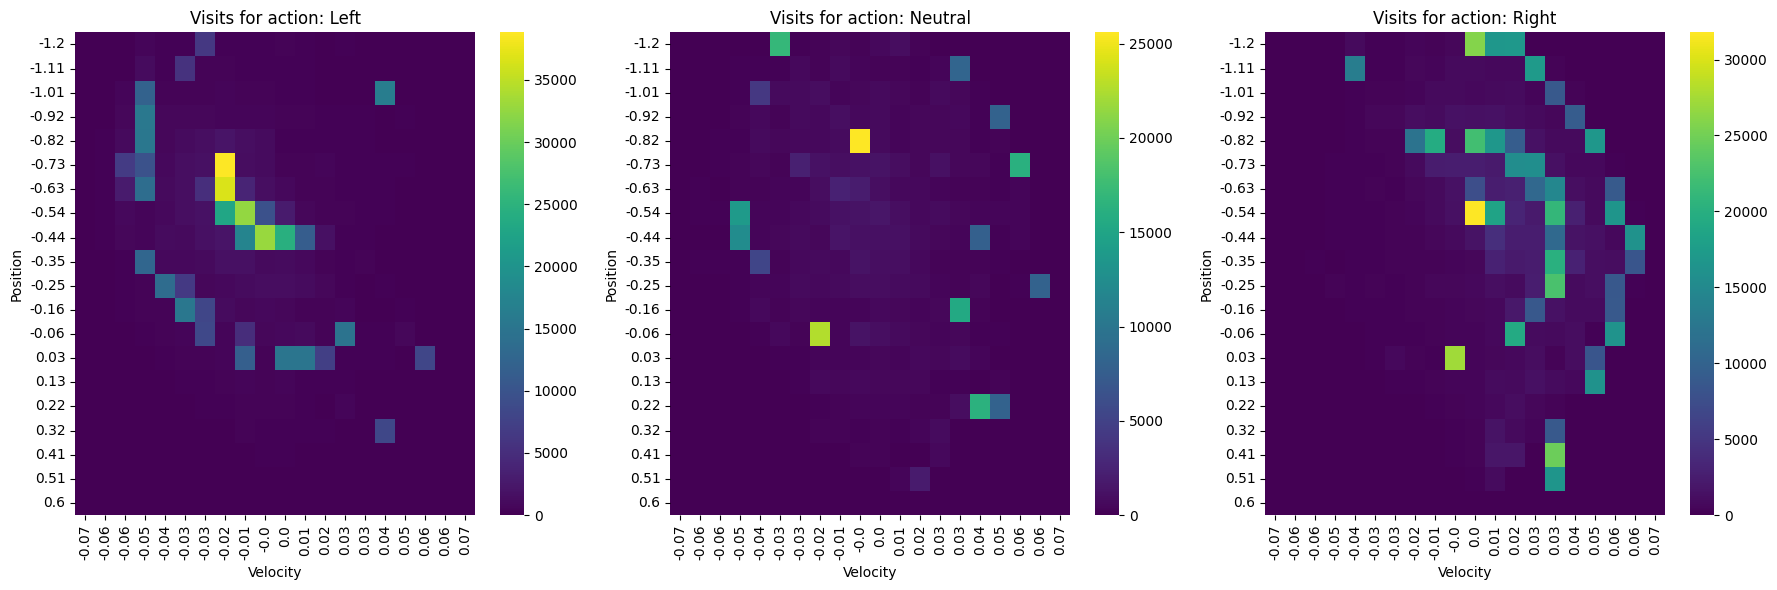

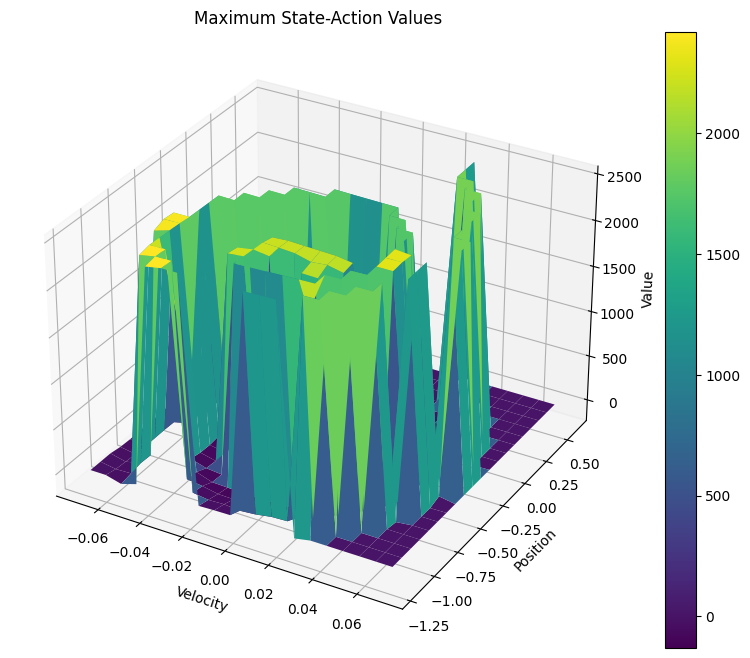

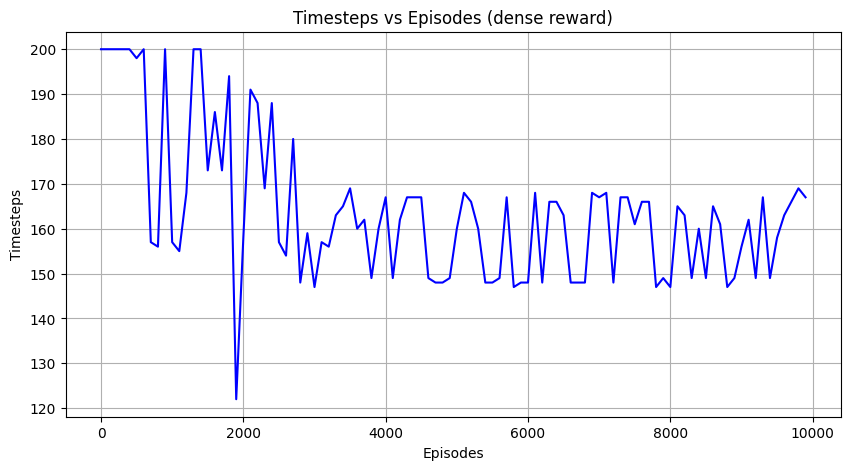

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Episode 1 Average reward: -213.87101793289293, Average timesteps: nan
Episode 100 Average reward: -200.71259874589836, Average timesteps: 200.0
Episode 200 Average reward: -183.31278118732064, Average timesteps: 200.0
Episode 300 Average reward: -176.53216441889552, Average timesteps: 200.0
First clear on episode 383
Episode 400 Average reward: -166.1277829015997, Average timesteps: 200.0
Episode 500 Average reward: -167.00484128813096, Average timesteps: 200.0
Episode 600 Average reward: -155.95356403775665, Average timesteps: 200.0
Episode 700 Average reward: -144.65073679915665, Average timesteps: 192.0
Episode 800 Average reward: -151.04088589025395, Average timesteps: 200.0
Episode 900 Average reward: -140.62022135774365, Average timesteps: 182.0
Episode 1000 Average reward: -144.78907212046016, Average timesteps: 194.0
Episode 1100 Average reward: -148.14677047986365, Average timesteps: 200.0
Episode 1200 Average reward: -138.30651976830544, Average timesteps: 200.0
Episode 1300 

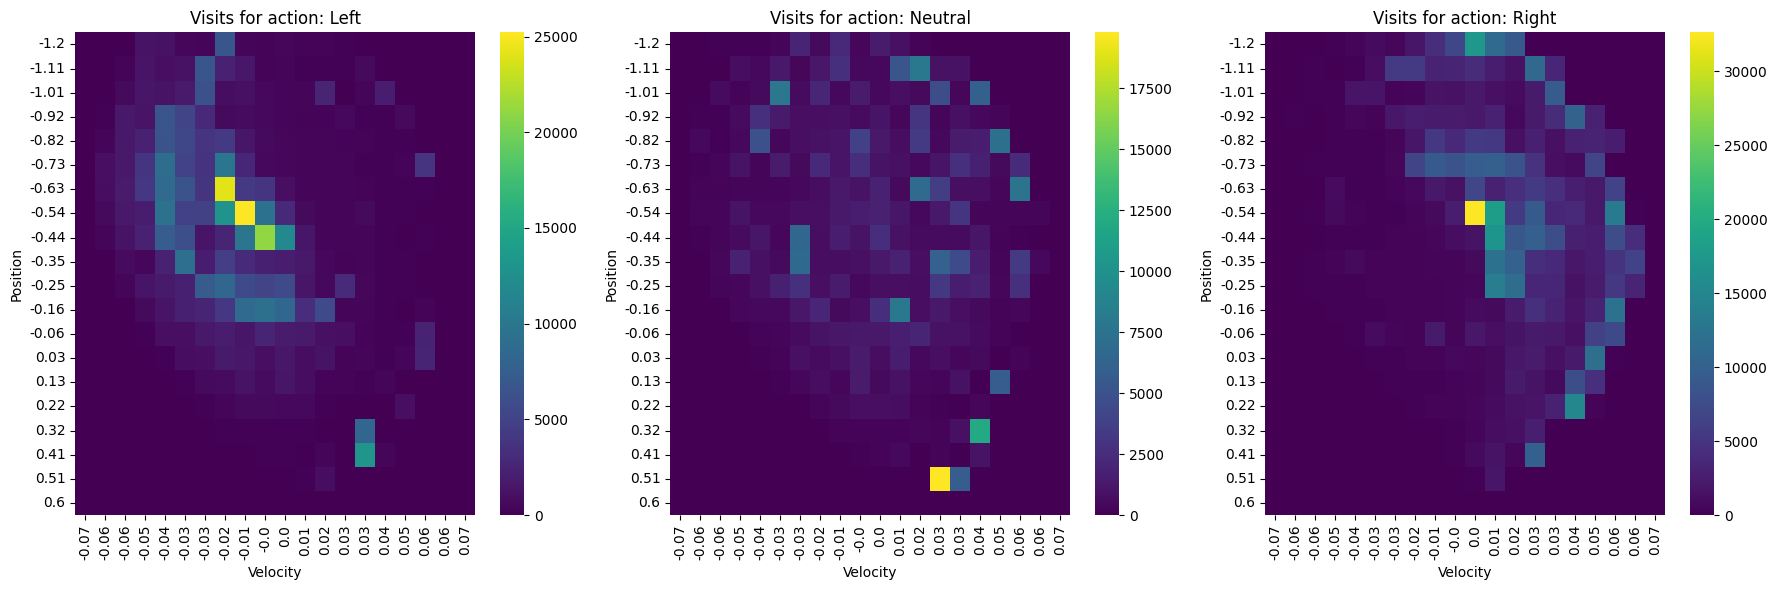

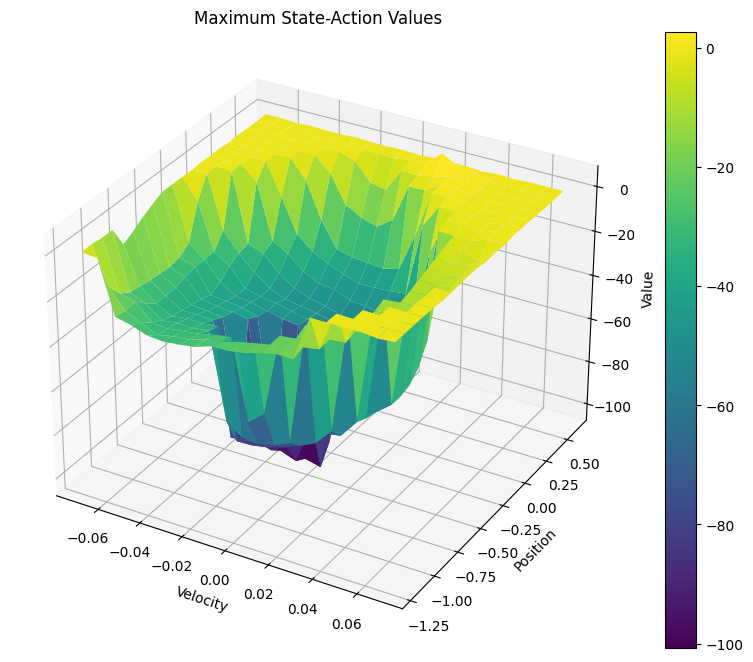

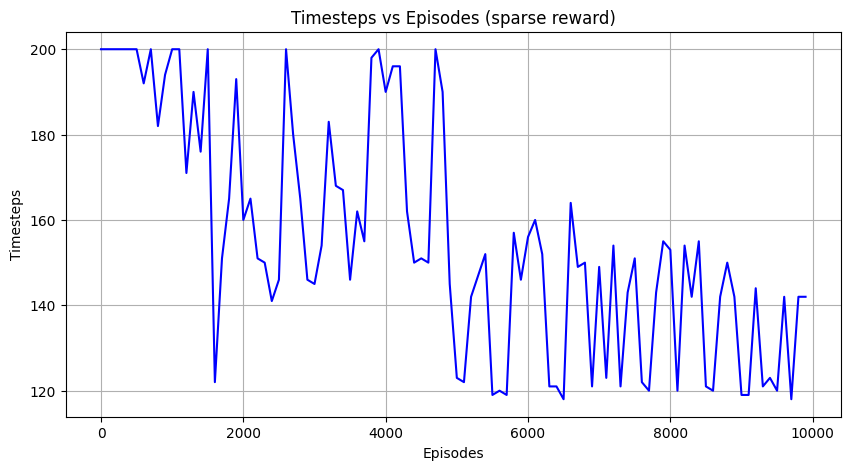

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Building video simulation_video.mp4.
Moviepy - Writing video simulation_video.mp4



Moviepy - Done !
Moviepy - video ready simulation_video.mp4


In [28]:
timesteps_dense, Qfinal_dense = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=dense_reward)

# Plot the timesteps obtained during training (dense reward)
plot_timesteps(timesteps_dense, 'Timesteps vs Episodes (dense reward)', 'Episodes')

# Visualize the Q-learning agent (dense reward)
HTML_video_qlearning_dense = watch_trained_agent(env, agent=Qfinal_dense, num_bins=(20, 20))
display(HTML_video_qlearning_dense)

# Train the Q-learning agent with custom sparse reward
timesteps_sparse, Qfinal_sparse = q_learning(env, learning_rate=0.2, epsilon=0.999, min_epsilon=0, num_episodes=10000, reward_function=custom_sparse_reward)

# Plot the timesteps obtained during training (sparse reward)
plot_timesteps(timesteps_sparse, 'Timesteps vs Episodes (sparse reward)', 'Episodes')

# Visualize the Q-learning agent (sparse reward)
HTML_video_qlearning_sparse = watch_trained_agent(env, agent=Qfinal_sparse, num_bins=(20, 20))
display(HTML_video_qlearning_sparse)